# TASK 3- knapsack problem
 **Using brute force (BF), Branch and Bound (BnB), Dynamic programming (DP) techniques as exact algorithms,
then using Greedy heurstic and Fully Polynomial Approximation Scheme (FPTAS) algorithms.**

Link to git repository: [https://gitlab.fit.cvut.cz/fabosamu/mi-paa-knapsack](https://gitlab.fit.cvut.cz/fabosamu/mi-paa-knapsack)

Knapsack problem is one of the easiest NP-hard problems. It is an *combinatorial optimization* problem.
We are given 

- $n$ - number of items
- $M$ - knapsack capacity
- $V = {v_1, v_2, ..., v_n}$ - weights of items we want to put into knapsack
- $P = {p_1, p_2, ..., p_n}$

Fn the assignment - we need to solve *contructive (0/1)* problem: 

Is it possible to construct a set $X = {x_1, x_2, ..., x_n}$, where each $x_i$ is 0 or 1, so we will satisfy:

- $v_1x_1 + v_2x_2 + ... + v_nx_n \leq M$, so that the weight of items do not exceed the capacity of knapsack

and this expression

- $p_1x_1 + p_2x_2 + ... + p_nx_n $ will be maximal possible (the sum of prices for items in knapsack is required to be maximal).

\[[1](https://moodle-vyuka.cvut.cz/mod/page/view.php?id=48346)\]

## Brute Force (BF) Algorithm

BF is pretty straightforward - we try each combination of (0/1) vector of length $n$ (as an indicator of appearence of $item_i$ in knapsack) -> so in total we check $2^n$ combinations, which is very exhaustive.

We can cut down some no-go "heavy" states - when expanding the state space, we are cutting down those solutions, which exceed the capacity of the knapsack for granted (we have a lot of heavy items - why do we want to add more if we already exceed capacity?).

In my solution I used recursion. `n, M, weights, prices, max_conf, max_price, visited` we can take as some "global" variables for the problem (some are constants):
```
Brute_knapsack(config: (0/1) vector, i, weight: vector, price: vector):
    if i == n:
        visited ++
        if price >= max_price:
            max_price = price
            max_conf = config
        return

    config[i] = 1
    if Sum(config * weights) <= M:
        Brute_knapsack(conf, i + 1, Sum(config * weights), Sum(config * prices))

    config[i] = 0
    Brute_knapsack(conf, i + 1, Sum(config * weights), Sum(config * prices))
```
After adding an item to knapsack, we check, if it does not exceed capacity - line 10.

## Branch and Bound (BnB) Algorithm

In this algorithm we use so-called cost function - in this case it is the price of added items - to cut down more states needed to visit.

Through recursion calls we keep the best seen solution (`max_price`). In each recursive call we can check if the solution from this "branch" would not be less than the actual one. If so, we cut this subtree and dont dive into it.

In each recursive call we know what to add / not add:
- I know items of which I already made a decision
- I know the actual price of knapsack

The **Upper Bound** we gather as actual `price` + Sum of prices of items, of which I have not decided yet. If this bound is less than the best price obtained, we do not need to call recursively this subtree.

In my BnB algorithm, I first **sort** the input so that prices are in descending order and weights are mapped to the same index as price. It is good to have it organized, as we can cut down states even faster - by looking on the items with high price first. To compute the upper bound, I sum the prices of yet unseen items and then compare it with maximal price already obtained. This is shown on lines 10 and 12.

```
config = sort_by_price(config)
Branch_bound(config, i, weight, price):
    if i == n:
        visited ++
        if price >= max_price:
            max_price = price
            max_conf = config
        return

    conf[i] = 1
    upper_bound = Sum(conf * prices) + Sum(prices[i:])

    if (Sum(config * weights) <= M) and (upper_bound >= max_price):
        branch_bound(config, i + 1, Sum(config * weights), Sum(conf * prices))

    conf[i] = 0
    branch_bound(config, i + 1, Sum(config * weights), Sum(conf * prices))
```

Again, `n, M, weights, prices, max_conf, max_price, visited` are constants and global variables.


## Dynamic Programming - decompostion by weight
### Naive implementation

A simple solution is to consider all subsets of items and calculate the total weight and value of all subsets. Consider the only subsets whose total weight is smaller than W. From all such subsets, pick the maximum value subset.

To consider all subsets of items, there can be two cases for every item: 
 - the item is included in the optimal subset, 
 - not included in the optimal set. 
 
Therefore, the maximum value that can be obtained from n items is max of following two values.
1. Maximum value obtained by n-1 items and W weight (excluding nth item).
2. Value of nth item plus maximum value obtained by n-1 items and W minus weight of the nth item (including nth item).

If weight of nth item is greater than W, then the nth item cannot be included and case 1 is the only possibility.

Pseudocode inspired by [geeksforgeeks](https://www.geeksforgeeks.org/0-1-knapsack-problem-dp-10/):
```
DP_Naive(W: max_capacity, wt: vector_weights, val: vector_prices, n: number_of_items):
    if n == 0 or W == 0:
        return 0
    if (wt[n - 1] > W):
        return DP_Naive(W, wt, val, n - 1)
    else:
        return max(val[n - 1] + DP_Naive(W - wt[n - 1], wt, val, n - 1),
                   DP_Naive(W, wt, val, n - 1))
```

### Iterative implementation

Since suproblems are evaluated again, this problem has Overlapping Subprolems property. So the 0-1 Knapsack problem has both properties (see this and this) of a dynamic programming problem. 

Like other typical Dynamic Programming(DP) problems, recomputations of same subproblems can be avoided by constructing a temporary array K\[\]\[\] in bottom up manner. Following is Dynamic Programming based implementation inspired by [geeksforgeeks](https://www.geeksforgeeks.org/0-1-knapsack-problem-dp-10/):

```
def DP_Iterative(W: max_capacity, wt: vector_weights, val: vector_prices, n: number_of_items):
    K = array of size W+1 x n+1

    for i in range(n + 1):
        for w in range(W + 1):
            if i == 0 or w == 0:
                K[i][w] = 0
            else if wt[i - 1] <= w:
                K[i][w] = max(val[i - 1] + K[i - 1][w - wt[i - 1]], K[i - 1][w])
            else:
                K[i][w] = K[i - 1][w]

    return K[n][W]
```


## Dynamic Programming (DP) - decompostion by price
### Iterative implementation

This approach is similar to DP technique above. What differs is the decomposition itself - by price - therefore we need to have the dimensions of the DP table (K) set as sum of prices of given instance times number of items.

$K(0,0) = 0$

$K(0,p) = \inf, \forall p > 0$

$K(i+1, p) = min(K(i, p), K(i, p-p_i+1)+w_i+1), \forall i > 0$.

From the resulting solutions in $W(n, c)$ we choose the solution, for which is $W(n, c) < M$ for the greatest price p.

```
def DP_iterative_by_price(M: max_capacity, wt: vector_weights, pc: vector_prices, n: number_of_items):
    sum_prices = Sum(pc)
    K = Zeros of size: (sum_prices + 1, n + 1)

    for i in range(n + 1):
        for p in range(sum_prices + 1):
            if p == 0:
                continue
            if i == 0:
                K[p][i] = Infinite
                continue

            if p == 1:
                K[p][i] = wt[i - 1] if (p == pc[i - 1]) else Infinite
                continue

            previous_weight = K[p][i - 1]
            index = p - pc[i - 1]

            if index < 0:
                K[p][i] = Infinite if (previous_weight == Infinite) else previous_weight
            else:
                if K[index][i - 1] == Infinite:
                    K[p][i] = min(previous_weight, K[index][i - 1])
                else:
                    K[p][i] = min(previous_weight, K[index][i - 1] + wt[i - 1])

    best_price = 0
    local_i = 0
    for i in reversed_range(sum_prices):
        local_i = i
        if K[i][n] <= M:
            best_price = i
            break
     
     includes = Zeros(n)

    c = n
    while local_i > 0:
        if K[local_i][c] == K[local_i][c - 1]:
            c -= 1
            continue

        local_i -= pc[c - 1]
        c -= 1
        includes[c] = 1

    return best_price, includes
```

## APR - approximative algorithms
Let's define:

- $P(S)$ Optimal value criterium of the solution $S$ 
- $APR(I)$ aprox. solution of instance $I$ 
- $OPT(I)$ optimální řešení instance $I$

APR algorithm has a relative quality $R$, if

- $\forall I: R \geq max\{ \frac{C(APR(I))}{C(OPT(I))}, \frac{C(OPT(I))}{C(APR(I))} \}$.

APR algorithm has a relative error $\varepsilon$, if

- $\forall I: \varepsilon \geq max\{ \frac{|C(APR(I)) - C(OPT(I))|}{ max\{C(OPT(I)), C(APR(I))\} } \}$.

Algorithm APR, which $\forall \varepsilon: 1 > \varepsilon > 0$ solve each instance of the problem with maximal relative error $\varepsilon$ in polynomial time $|I|$ - as a instance size we call Polynomial Time Approximation Scheme.

PTAS, which time depends polynomially on $\frac{1}{\varepsilon}$ we call **Fully Polynomial Approximation Scheme**


### Greedy heuristic algorithm

First we sort the items by ratio $\frac{weight_i}{price_i}$

Then we start adding an item with the highest ratio and continue adding others in descending order. When the backpack is full, we return the price of added items.

```
def Greedy(M: max_capacity, weights: vector_weights, prices: vector_prices, n: number_of_items):
    idxs = Argsort(pc / weights, Descending=True)
    wt = weights[idxs]
    pc = prices[idxs]
    max_price = 0
    for i in range(len(wt)):
        if M >= wt[i]:
            max_price = max_price + pc[i]
            M -= wt[i]
        else:
            return max_price
    return max_price
```

This heuristic has a problem - we might omit the most valuable item, which still can fit into backpack. 

Let's construct this kind of instance:

$M = kn, k > 0$ 

$v_1 = v_2 = \cdots = v_{n-1} = k$ and $v_n = M$

$p_1 = p_2 = \cdots = p_n-1 = k$ and $p_n = M-1$

This heuristic take all 1..n-1 items - ratio of these is 1 - while the ratio of the last n-th item is $\frac{M-1}{M}$. If we continue adding things in this order, the latest item cannot fit into backpack. Overall price is n-1, while optimal is the single n-th item. 




### Modified Greedy Heuristic - Redux

For given instance we first obtain the solution by greedy heuristic algorithm. Then we compare it with the most-valued item, which can still fit into the backpack.

```
def GreedyRedux(M: max_capacity, weights: vector_weights, prices: vector_prices, n: number_of_items):
    greedy_max_price = Greedy(M, weights, prices, n)
        
    idxs = Argsort(prices, Descending=True)
    pc = prices[idxs]
    wt = weights[idxs]
    solo_max_price = 0
    for i in range(len(pc)):
        if wt[i] <= M:
            solo_max_price = pc[i]
     
    return max(greedy_max_price, solo_max_price)
        
```


### Fully Polynomial Approximation Scheme (FPTAS) algorithm

In the beginning, we are given $\varepsilon$ as the maximal relative error we want to have.

- Let $C_M = max{c_1, \cdots, c_n}$
- Let $K_ = \frac{\varepsilon C_M}{n}$
- For $i = \{ 1, \cdots, n \}: c'_i = \lfloor \frac{c_i}{K} \rfloor$ - this is how we "approximate". We "cut" down some least significant bits (LSB) of the prices for each item.

Then we solve this modified instance by DP with decomposition by price.

The pseudocode is straightforward:

```
def FPTAS(M, weights, prices, n, eps):
    C_M = Max(prices)
    K = (eps * C_M) / n
    prices_red = Floor(prices / K)
    
    price, witness = DP_iterative_by_price(M, weights, prices_red, n)

    return Sum(prices[witness])
```


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys
import os
sys.path.append("../02/")
from utilities import Problem
import solvers as S
import subprocess
import math

# Introduction

Maintenance and overhead around input/output is in the `../02/main.py` file - where I also test the righteousness and optimality of the found witnesses.
Helper classes are in `../02/utilities.py` file, algorithms are implemented in `../02/solvers.py` file.

These result sets contain information from solution files, where construction problem is solved. 
It comes with the optimal price for each instance and also the optimal vector of (0/1) indicators of appearance in the result set. 

In my result sets, I check if I reached the optimal price (column **status** - witness check). This is the solution of the *constructive problem* as assigned.

# Algorithms comparison
## CPU runtime measurements

I measure time with `timeit`. For each instance I reset the timer twice and run the solver 2 times. In total, I have 2 measuerments and then I take the average and put it into the table.

I ran this measurements on a MacBook Pro machine:
- Processor: 2,5 GHz Dual-Core Intel Core i7
- Memory: 16 GB 2133 MHz LPDDR3


# Brute Force
## Sensitivity

In [2]:
n = 15  # n of items
N = 100  # N of instances
W = 500 # max weight
C = 300 # max value
ms = [0.01, 0.25, 0.5, 0.75, 1] # Capacity to sum of weights ratio as a fixed value or interval of the uniform distribution
k = 1     # granularity

ws = ['bal', 'light', 'heavy']   # majority of light|heavy items
cs = ['uni', 'corr', 'strong']   # correlation with weights uni|corr|strong

def solve_instances(inst_lines, solver_c, time=True):
    results = []
#     print("|" * len(inst_lines))
    for i in range(0, len(inst_lines)):
#         print("|", end="")
        inst = list(map(int, inst_lines[i].split()))
        p = Problem(inst[0], inst[1], inst[2], np.array(inst[3::2]), np.array(inst[4::2]))
        solver = solver_c(p)
        if time:
            t = %timeit -oq -r 2 -n 2 solver.solve()
            results.append(np.mean(t.all_runs))
        else:
            solver.solve()
            results.append(solver.p.visited)
    return pd.Series(results)

def generate(n, N, W, C, m, w, c, k, verbose=False):
    if type(m) is tuple:
        str_m = format(m[0], '.20f') + ',' + format(m[1], '.20f')
    else:
        str_m = format(m, '.20f')
    completed = subprocess.run(
        ['generator/kg2', '-n', str(n), '-N', str(N), '-W', str(W), '-C', str(C), 
         '-m', str_m, 
         '-w', str(w),
         '-c', str(c),
         '-k', format(k, '.20f')
        ], 
        capture_output=True, text=True)
    stdout = completed.stdout
#     if completed.stderr is not None:
#         print(completed.stderr)
    result = stdout.split('\n')[:-1]
    if verbose:
        print(result)
    return result

def permute(d, N, stdin: str, verbose=False):
    completed = subprocess.run(
        ['generator/kg_perm', '-d', str(d), '-N', str(N)], 
        capture_output=True, text=True, input=stdin, encoding='ascii')
    stdout = completed.stdout
    result = stdout.split('\n')[:-1]
    if verbose:
        print(result)
    return result
    

def plot_all(n, N, W, C, ms, k, solver, time=True):
    
    fig, axs = plt.subplots(len(ws), len(cs), sharey=True, sharex=True, figsize=(20, 10), dpi=200)
    for (x,y), value in np.ndenumerate(axs):
        axs[x,y].yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

    for col in range(len(ws)):
        print(ws[col], end='; ')
        for row in range(len(cs)):
            print(cs[row], end=', ')
            df = pd.DataFrame()
            for m in ms:
                input_lines = generate(n, N, W, C, m, ws[col], cs[row], k)
                df[str(m)] = solve_instances(input_lines, solver, time)
            ax = axs[row, col]
            ax.boxplot(df.values)
            ax.set_title(ws[col])
            ax.set_ylabel("Visited " + cs[row] + " " + str((row, col)))
            ax.set_xlabel("m")
            ax.set_xticklabels(ms)

Above are helper functions for generating, solving and plotting the results of an experiment.

Below is my first experiment, showing how the number of visited states differ, when sending various parameters to the generator. Each row is the `w` parameter, and each column is a different `c` parameter.

bal; uni, corr, strong, light; uni, corr, strong, heavy; uni, corr, strong, 

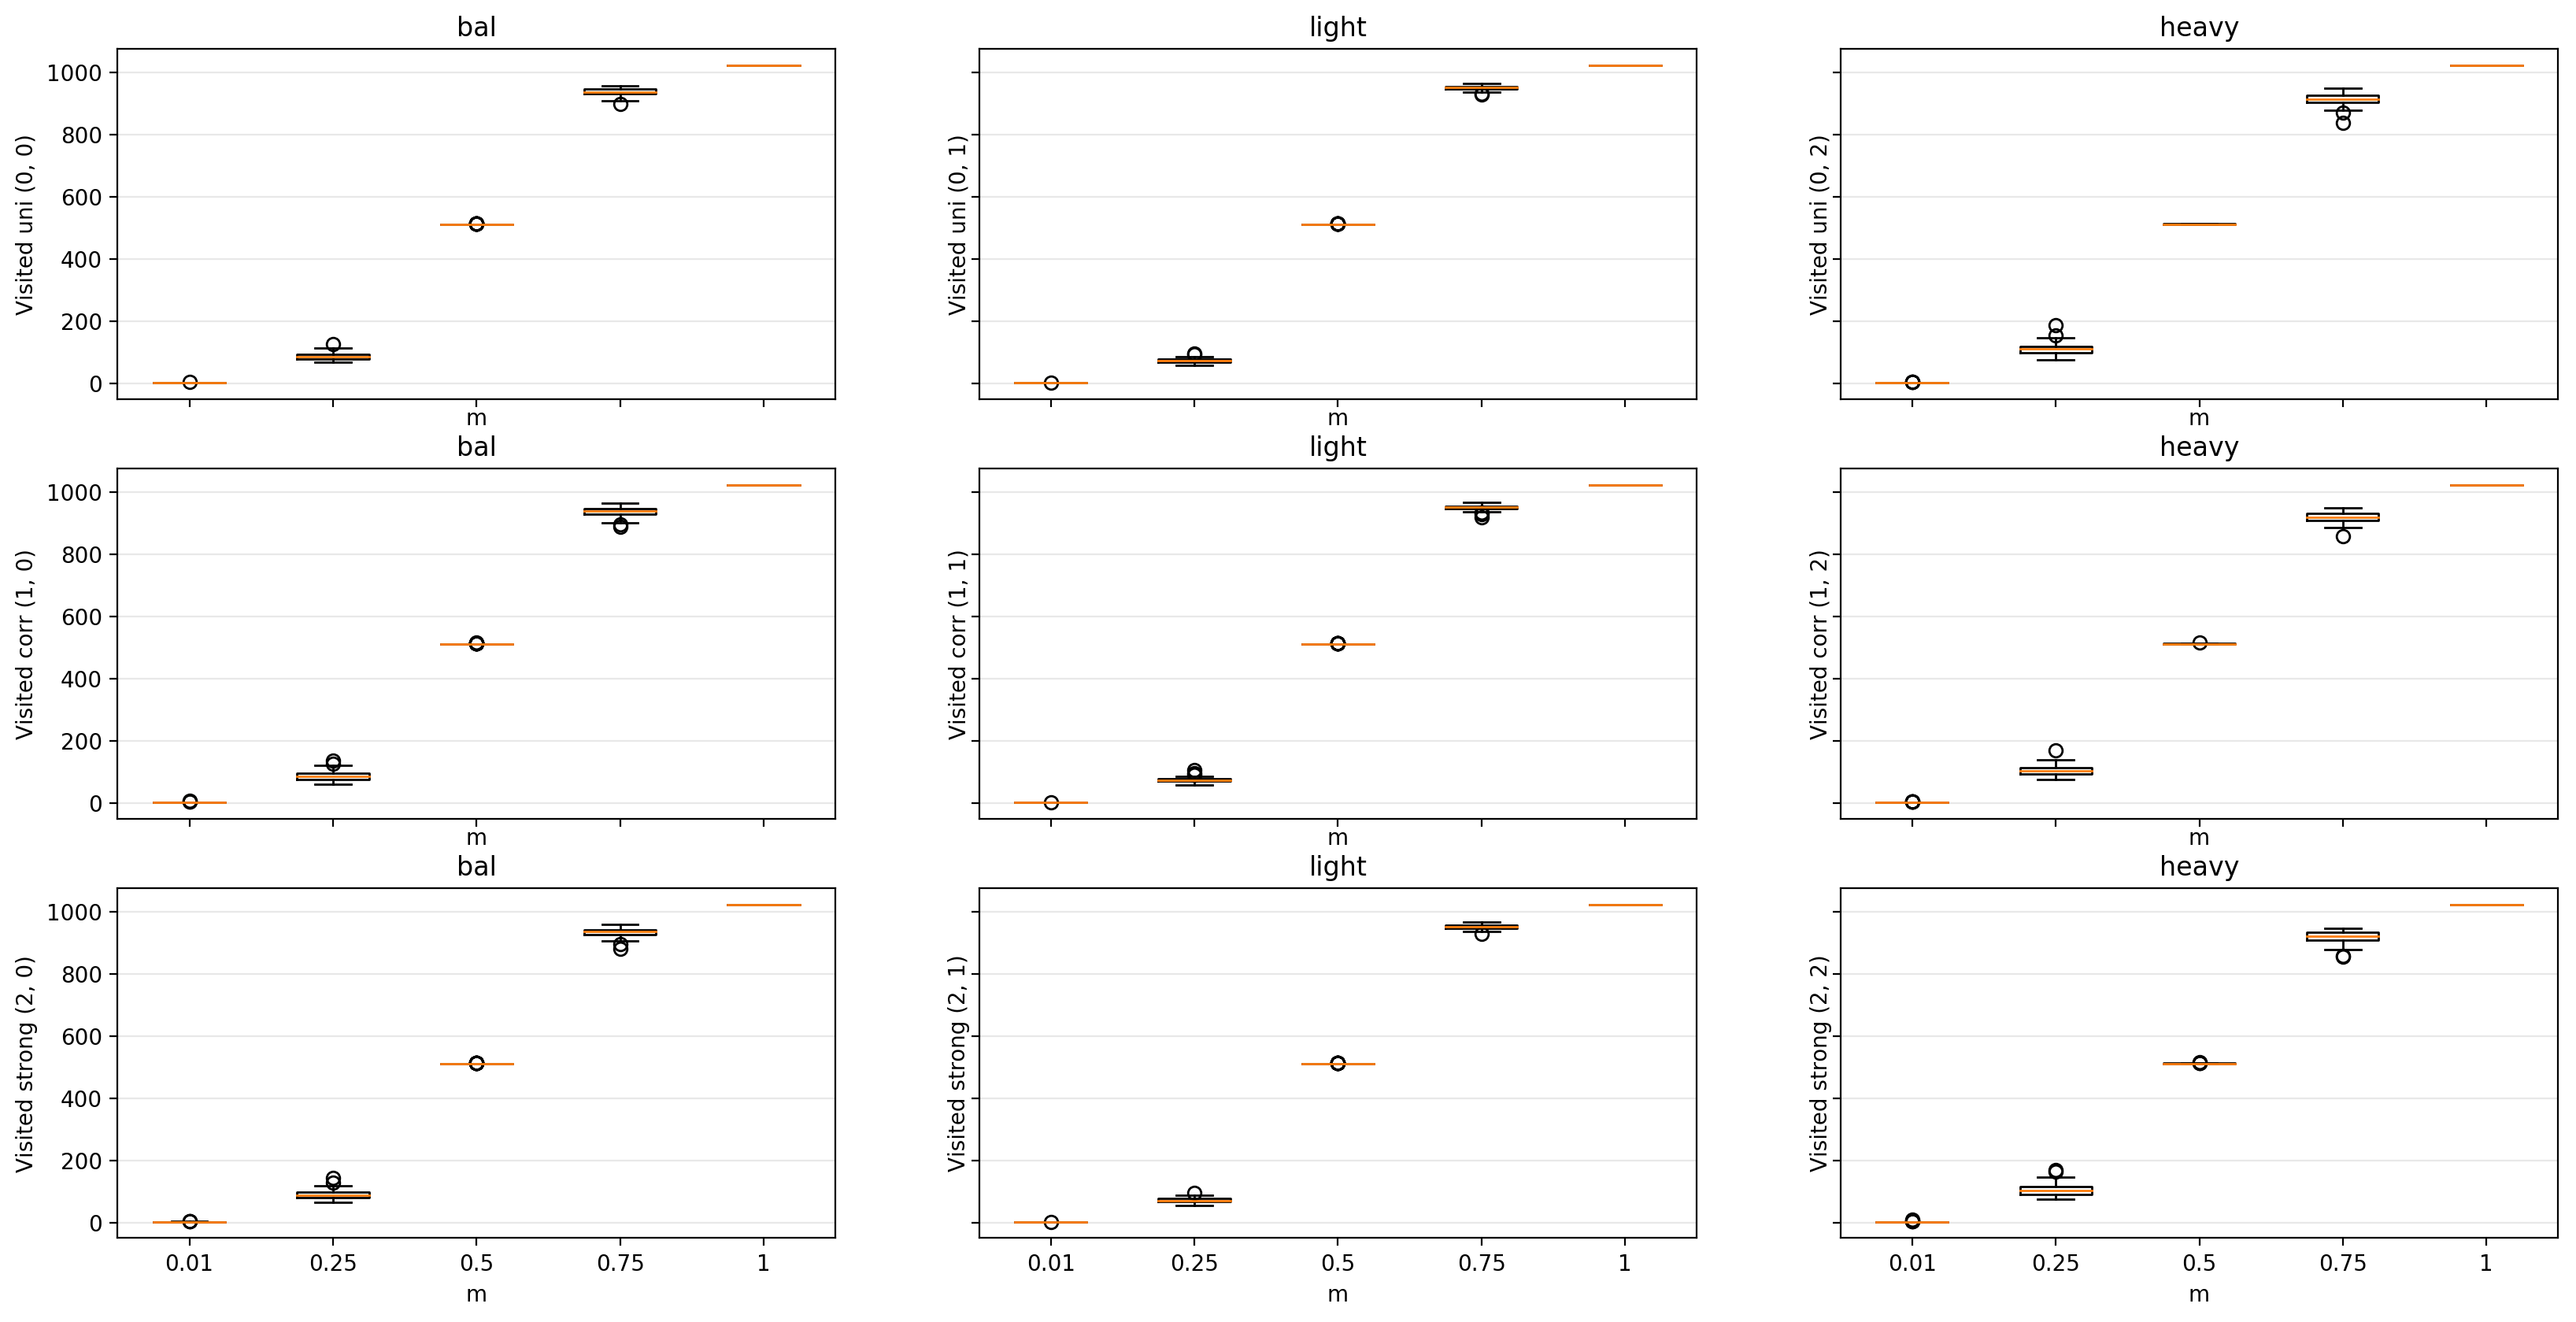

In [357]:
plot_all(10, 50, W, C, ms, k, S.Brute, False)

Not much happening. Let's take a look on the performance, if I will change any of the values. More precisely - W, C, k.

bal; uni, corr, strong, light; uni, corr, strong, heavy; uni, corr, strong, 

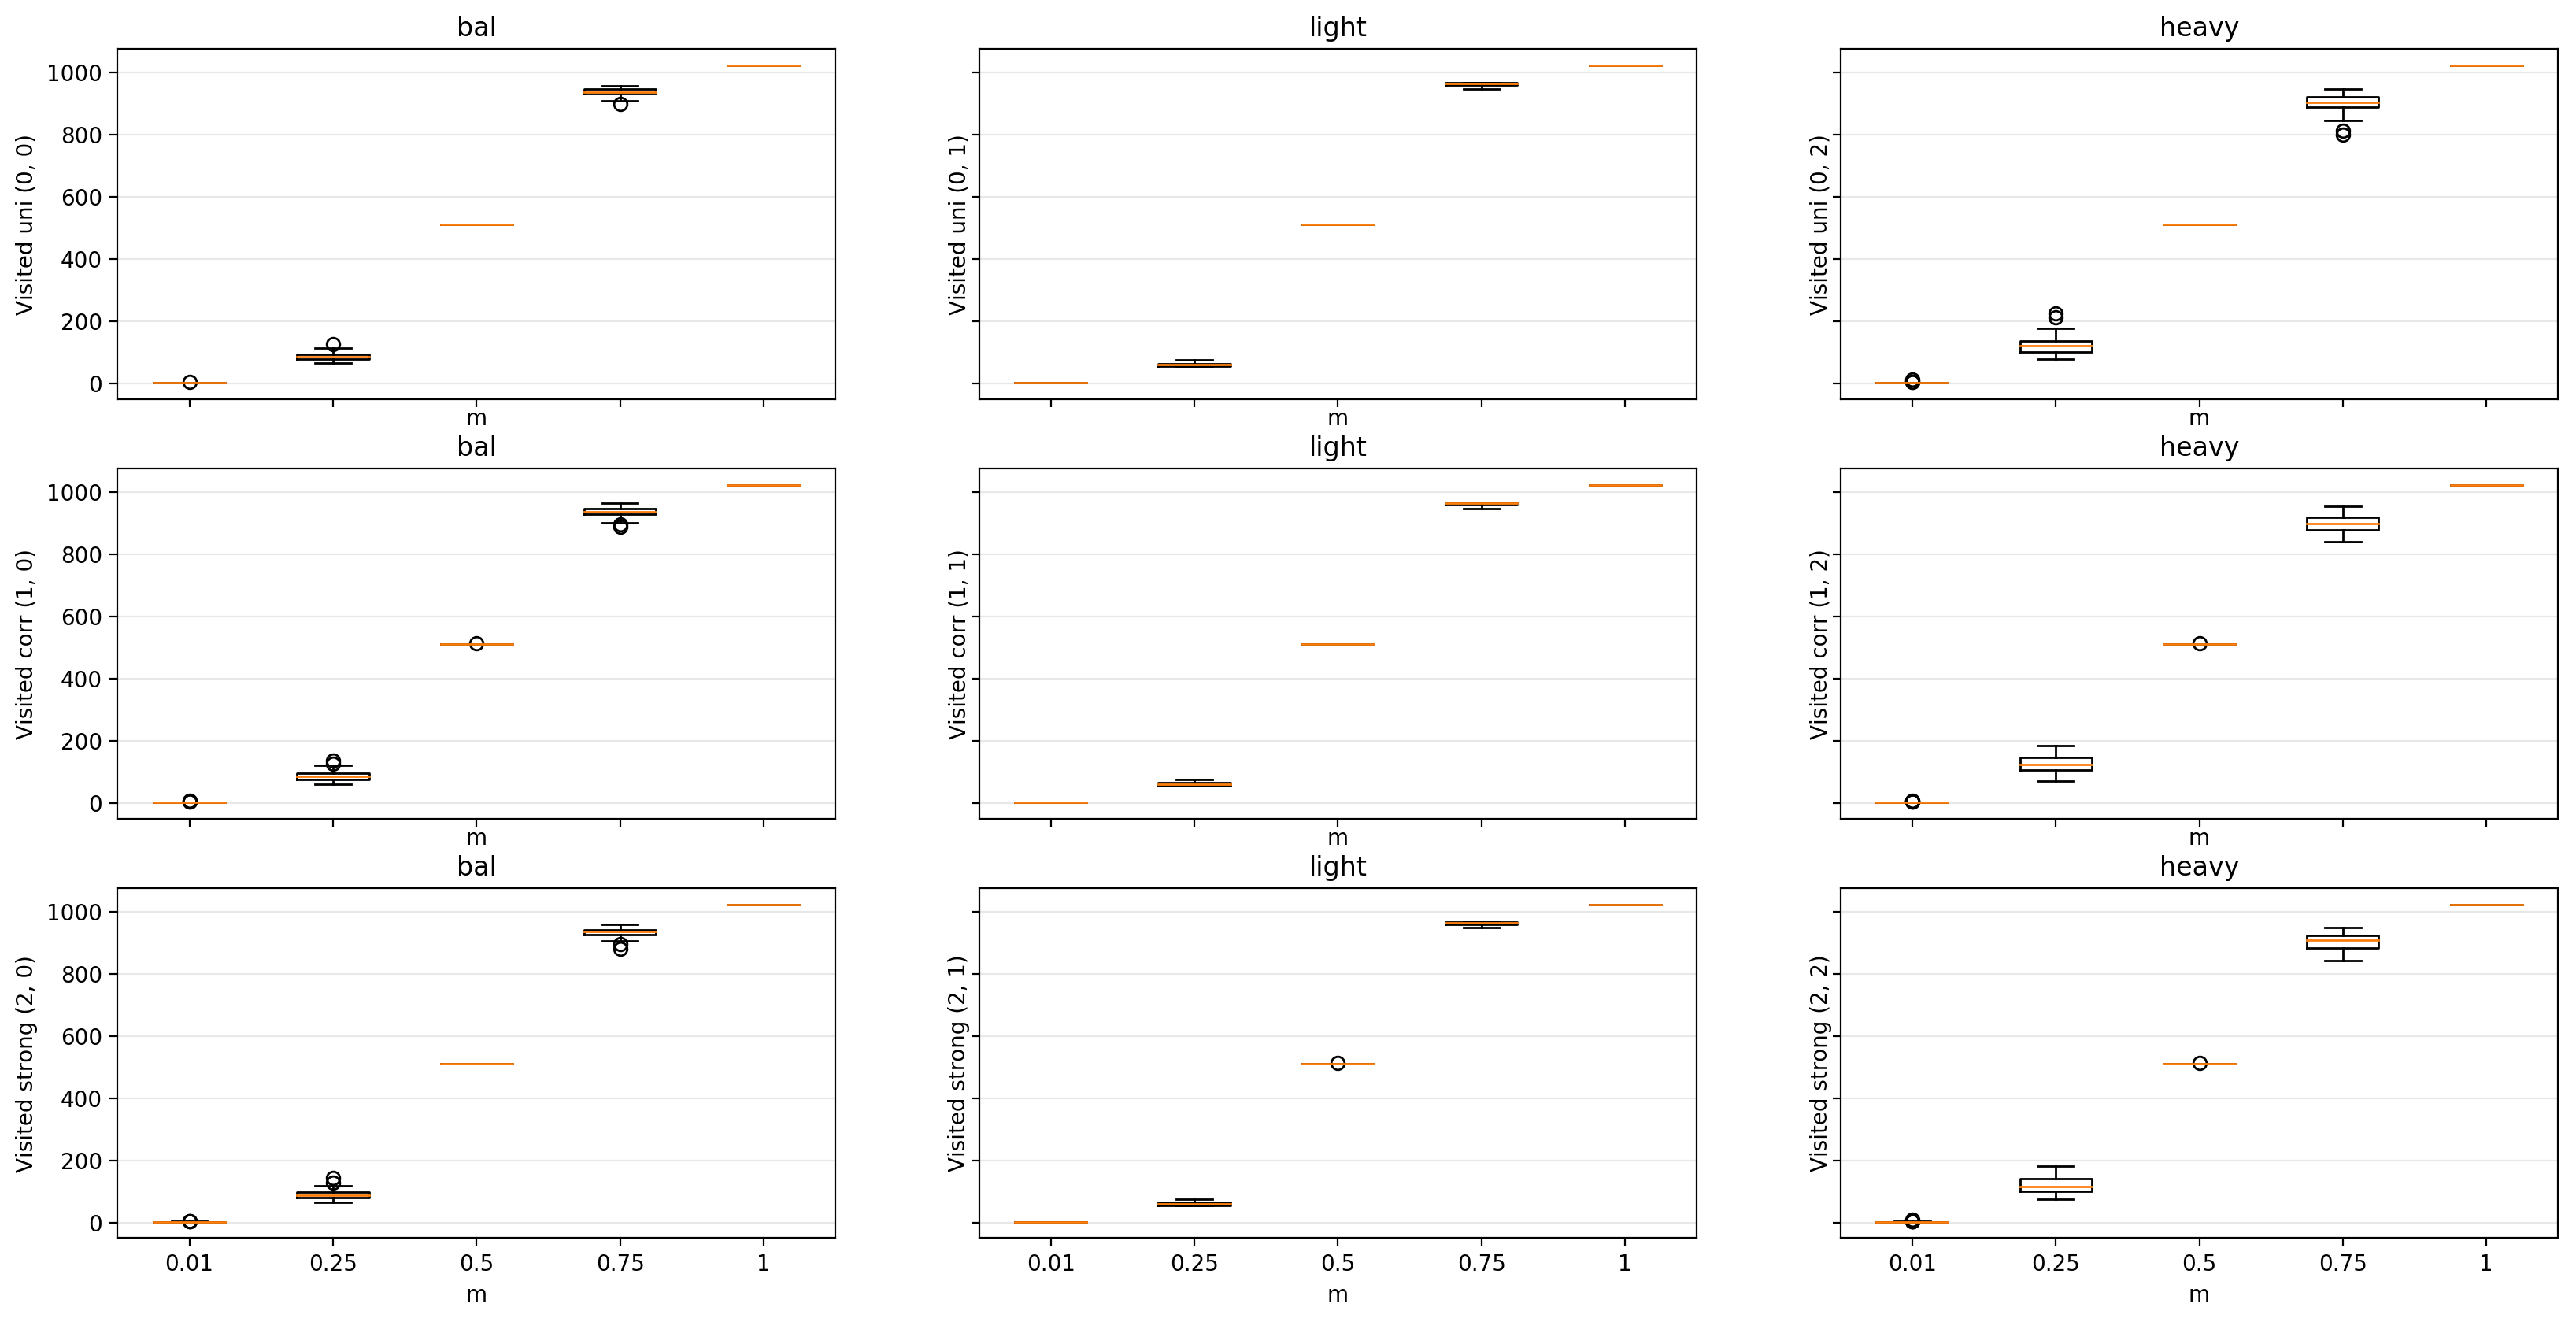

In [358]:
plot_all(10, 50, 10000, 5000, ms, 4, S.Brute, False)

Brute Force doesn't seem to be sensitive to changeable generator parameters. It appears to be unsensitive to input data - but those where the ratio of ligh/heavy is changing, we can see how "salted" brute force (with removing items too heavy for the capacity) is working nice (otherwise complexity would be $2^n$ for any kind of input). 

If I was not removing states with large-weighted items in backpack, I assume All measurements would look like the last one.

Let's take a look on a `k` parameter and check the hypothesis, that it is going to work the same:

In [364]:
df = pd.DataFrame()
for k in np.linspace(-1, 5, 9):
    input_lines = generate(10, 100, 1000, C, 0.3, 'heavy', 'corr', k)
    df[str(k)] = solve_instances(input_lines, S.Brute, False)

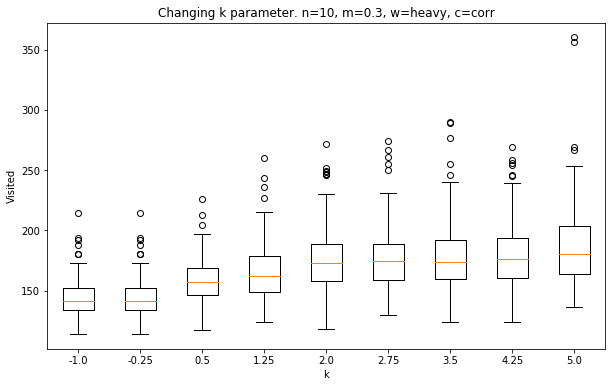

In [369]:
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.boxplot(df.values)
ax1.set_xticklabels(df.columns)
ax1.set_xlabel('k')
ax1.set_ylabel('Visited')
ax1.set_title('Changing k parameter. n=10, m=0.3, w=heavy, c=corr')
plt.show()

In [366]:
dfl = pd.DataFrame()
for k in np.linspace(-1, 5, 9):
    input_lines = generate(10, 100, 1000, C, 0.3, 'light', 'corr', k)
    dfl[str(k)] = solve_instances(input_lines, S.Brute, False)

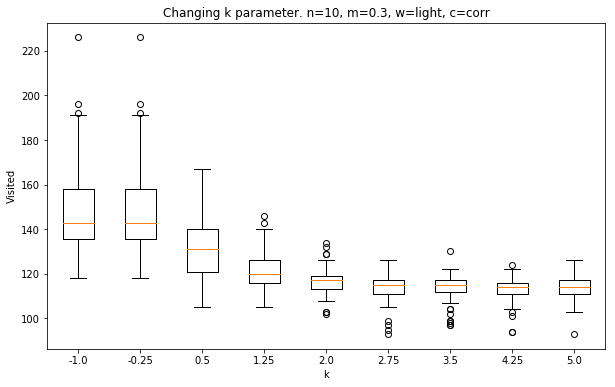

In [370]:
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.boxplot(dfl.values)
ax1.set_xticklabels(dfl.columns)
ax1.set_xlabel('k')
ax1.set_ylabel('Visited')
ax1.set_title('Changing k parameter. n=10, m=0.3, w=light, c=corr')
plt.show()

Parameter `k` has effect only when 'heavy' or 'light' is passed into the `w` parameter - of course. 

What we can see in abouve graph, that if the majority of items would be heavier, the probability boosted with `k` is putting more and more heavy items - still acceptable for the backpack - therefore it needs to visit more states.

The probability for lighter items is computed symmetricaly.

## Robustness
There is no need to compute robustness, since my algorithm already sorts the input. Even if not, it would be redundant to check the robustness for the brute force algorithm, since it must always check almost each state (if cutting down large items, there is the same result).

# Branch And Bound
## Sensitivity

Below I will show on fixed parameters `n=15, W=500, C=300, k=1`, how Branch and Bound (BnB) algorithm is doing.
$2^{15} = 32 768$ should be the maximum number of visited states (if brute-forcing).

In [12]:
ms = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

bal; uni, corr, strong, light; uni, corr, strong, heavy; uni, corr, strong, 

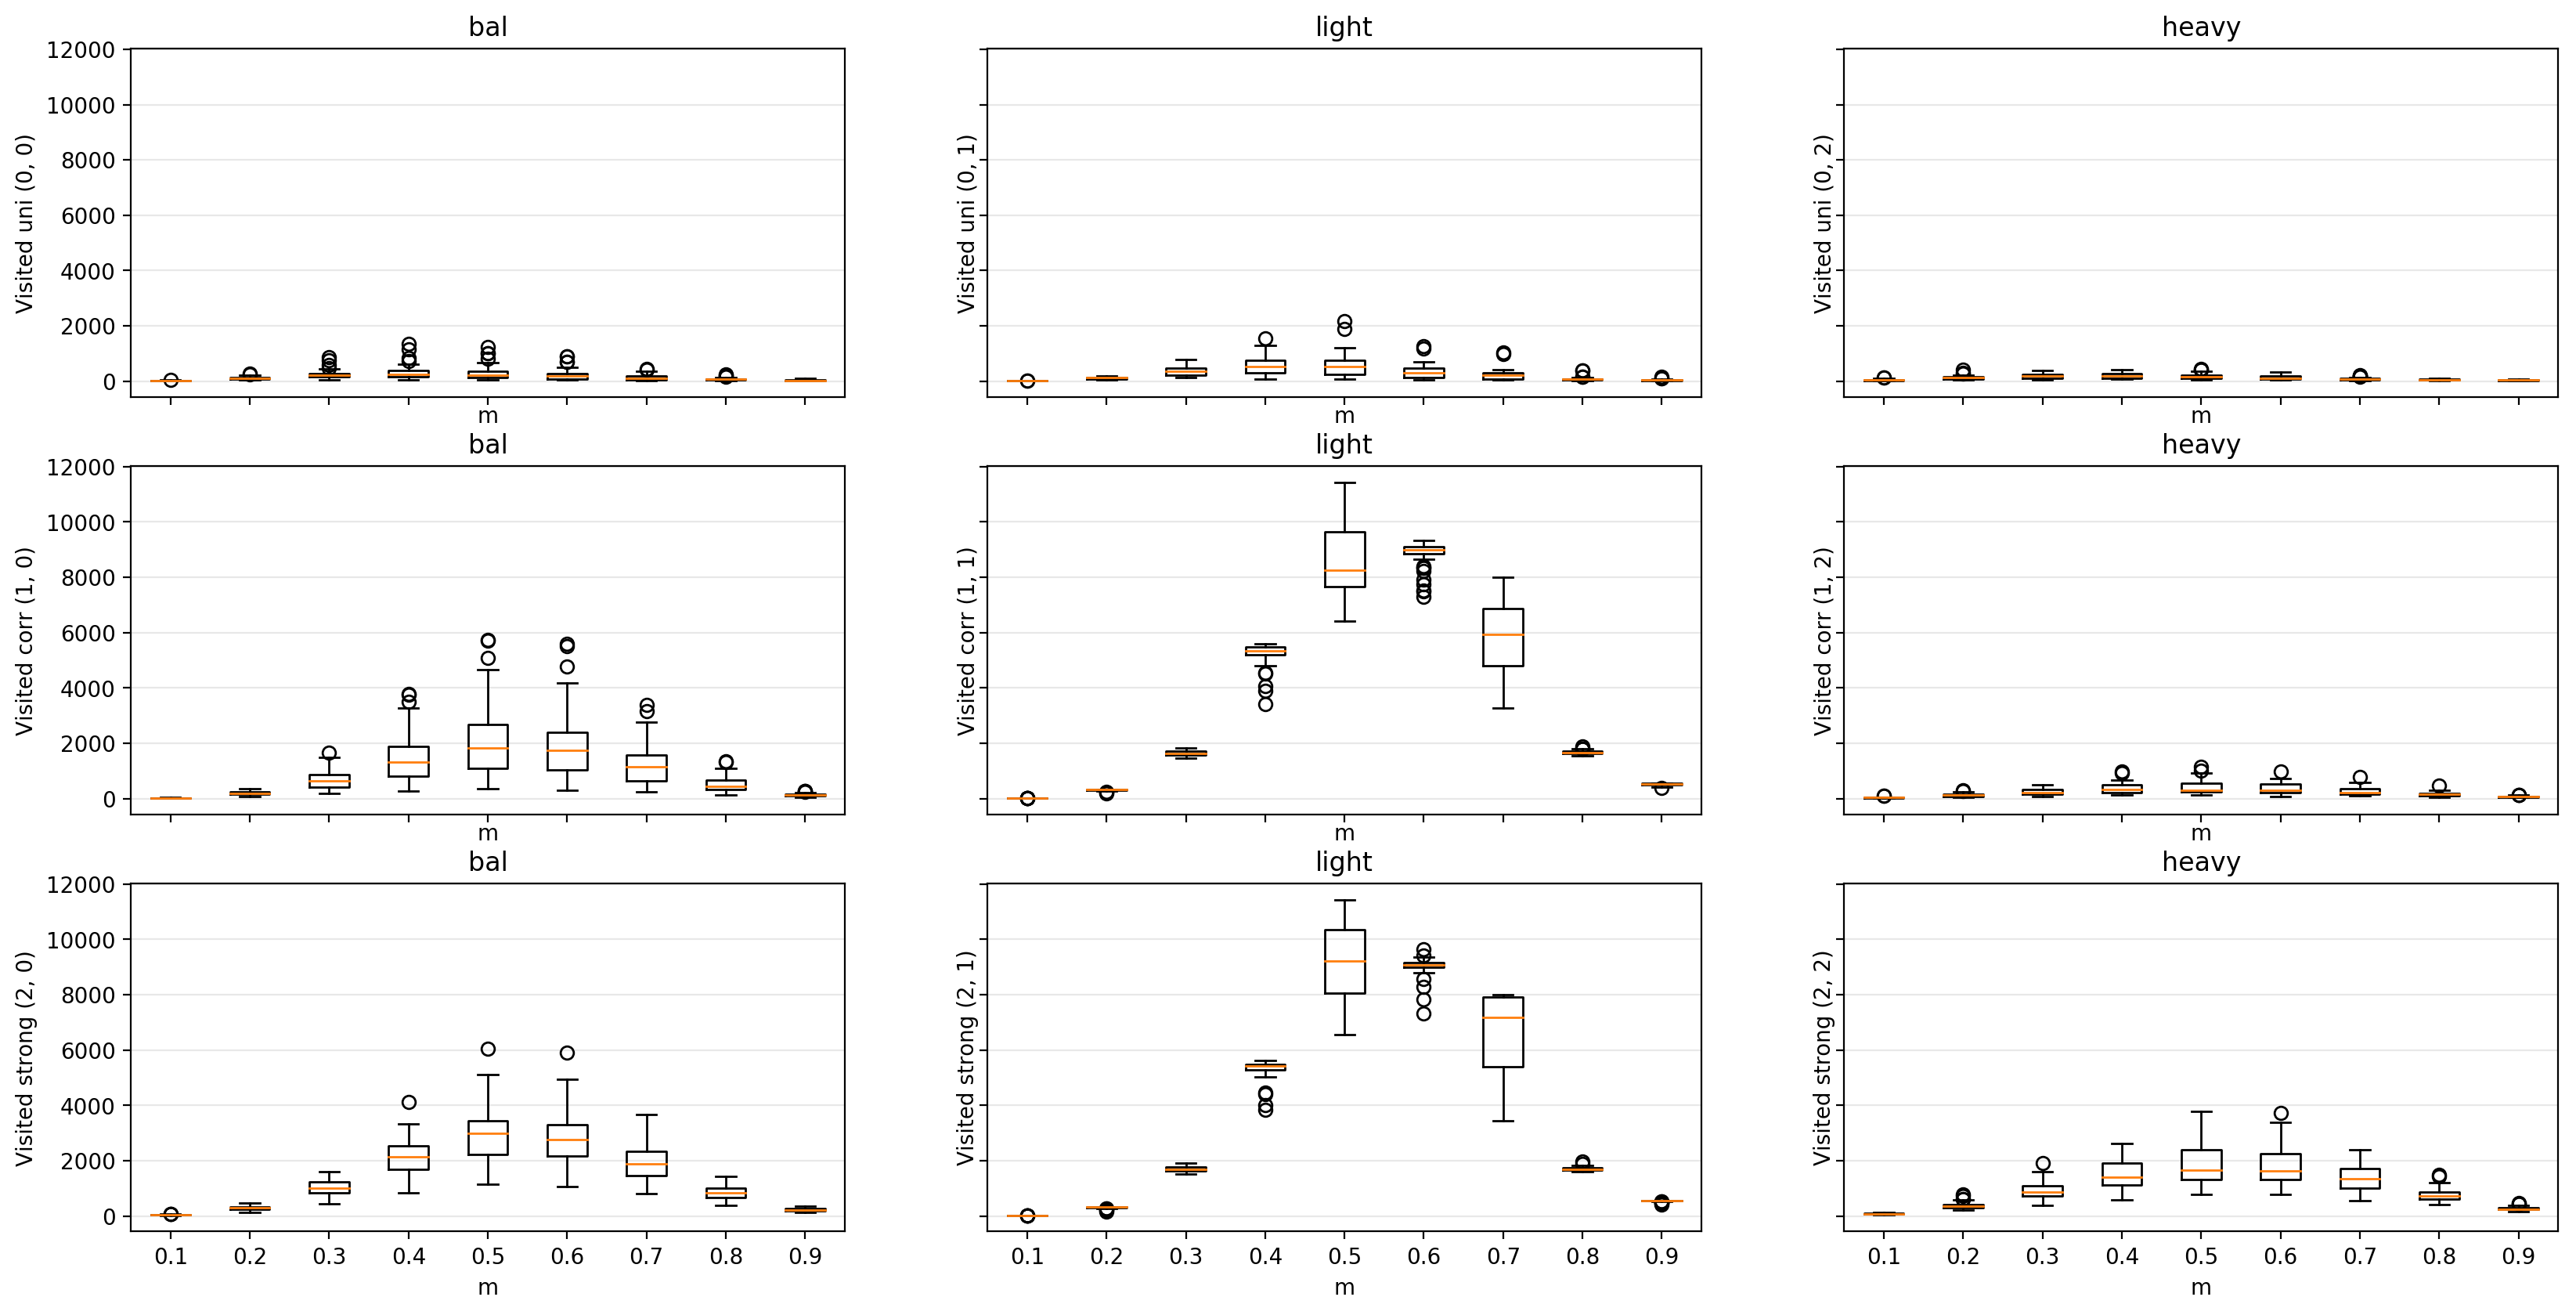

In [374]:
plot_all(15, 50, W, C, ms, 1, S.BranchBound, time=False)

In the first row of the visualization, we can see that if the correlation of the price and weight is uniform, there are no massive changes in the number of visited states. 

However, in the second row, when price and weights are correlated, we can see, that if the correlation coefficient `m` is around 0.5, the complexity rises rapidly. Mainly when light/heavy items are balanced and light items are in majority.

In the third row we can see the same trend.

bal; uni, corr, strong, light; uni, corr, strong, heavy; uni, corr, strong, 

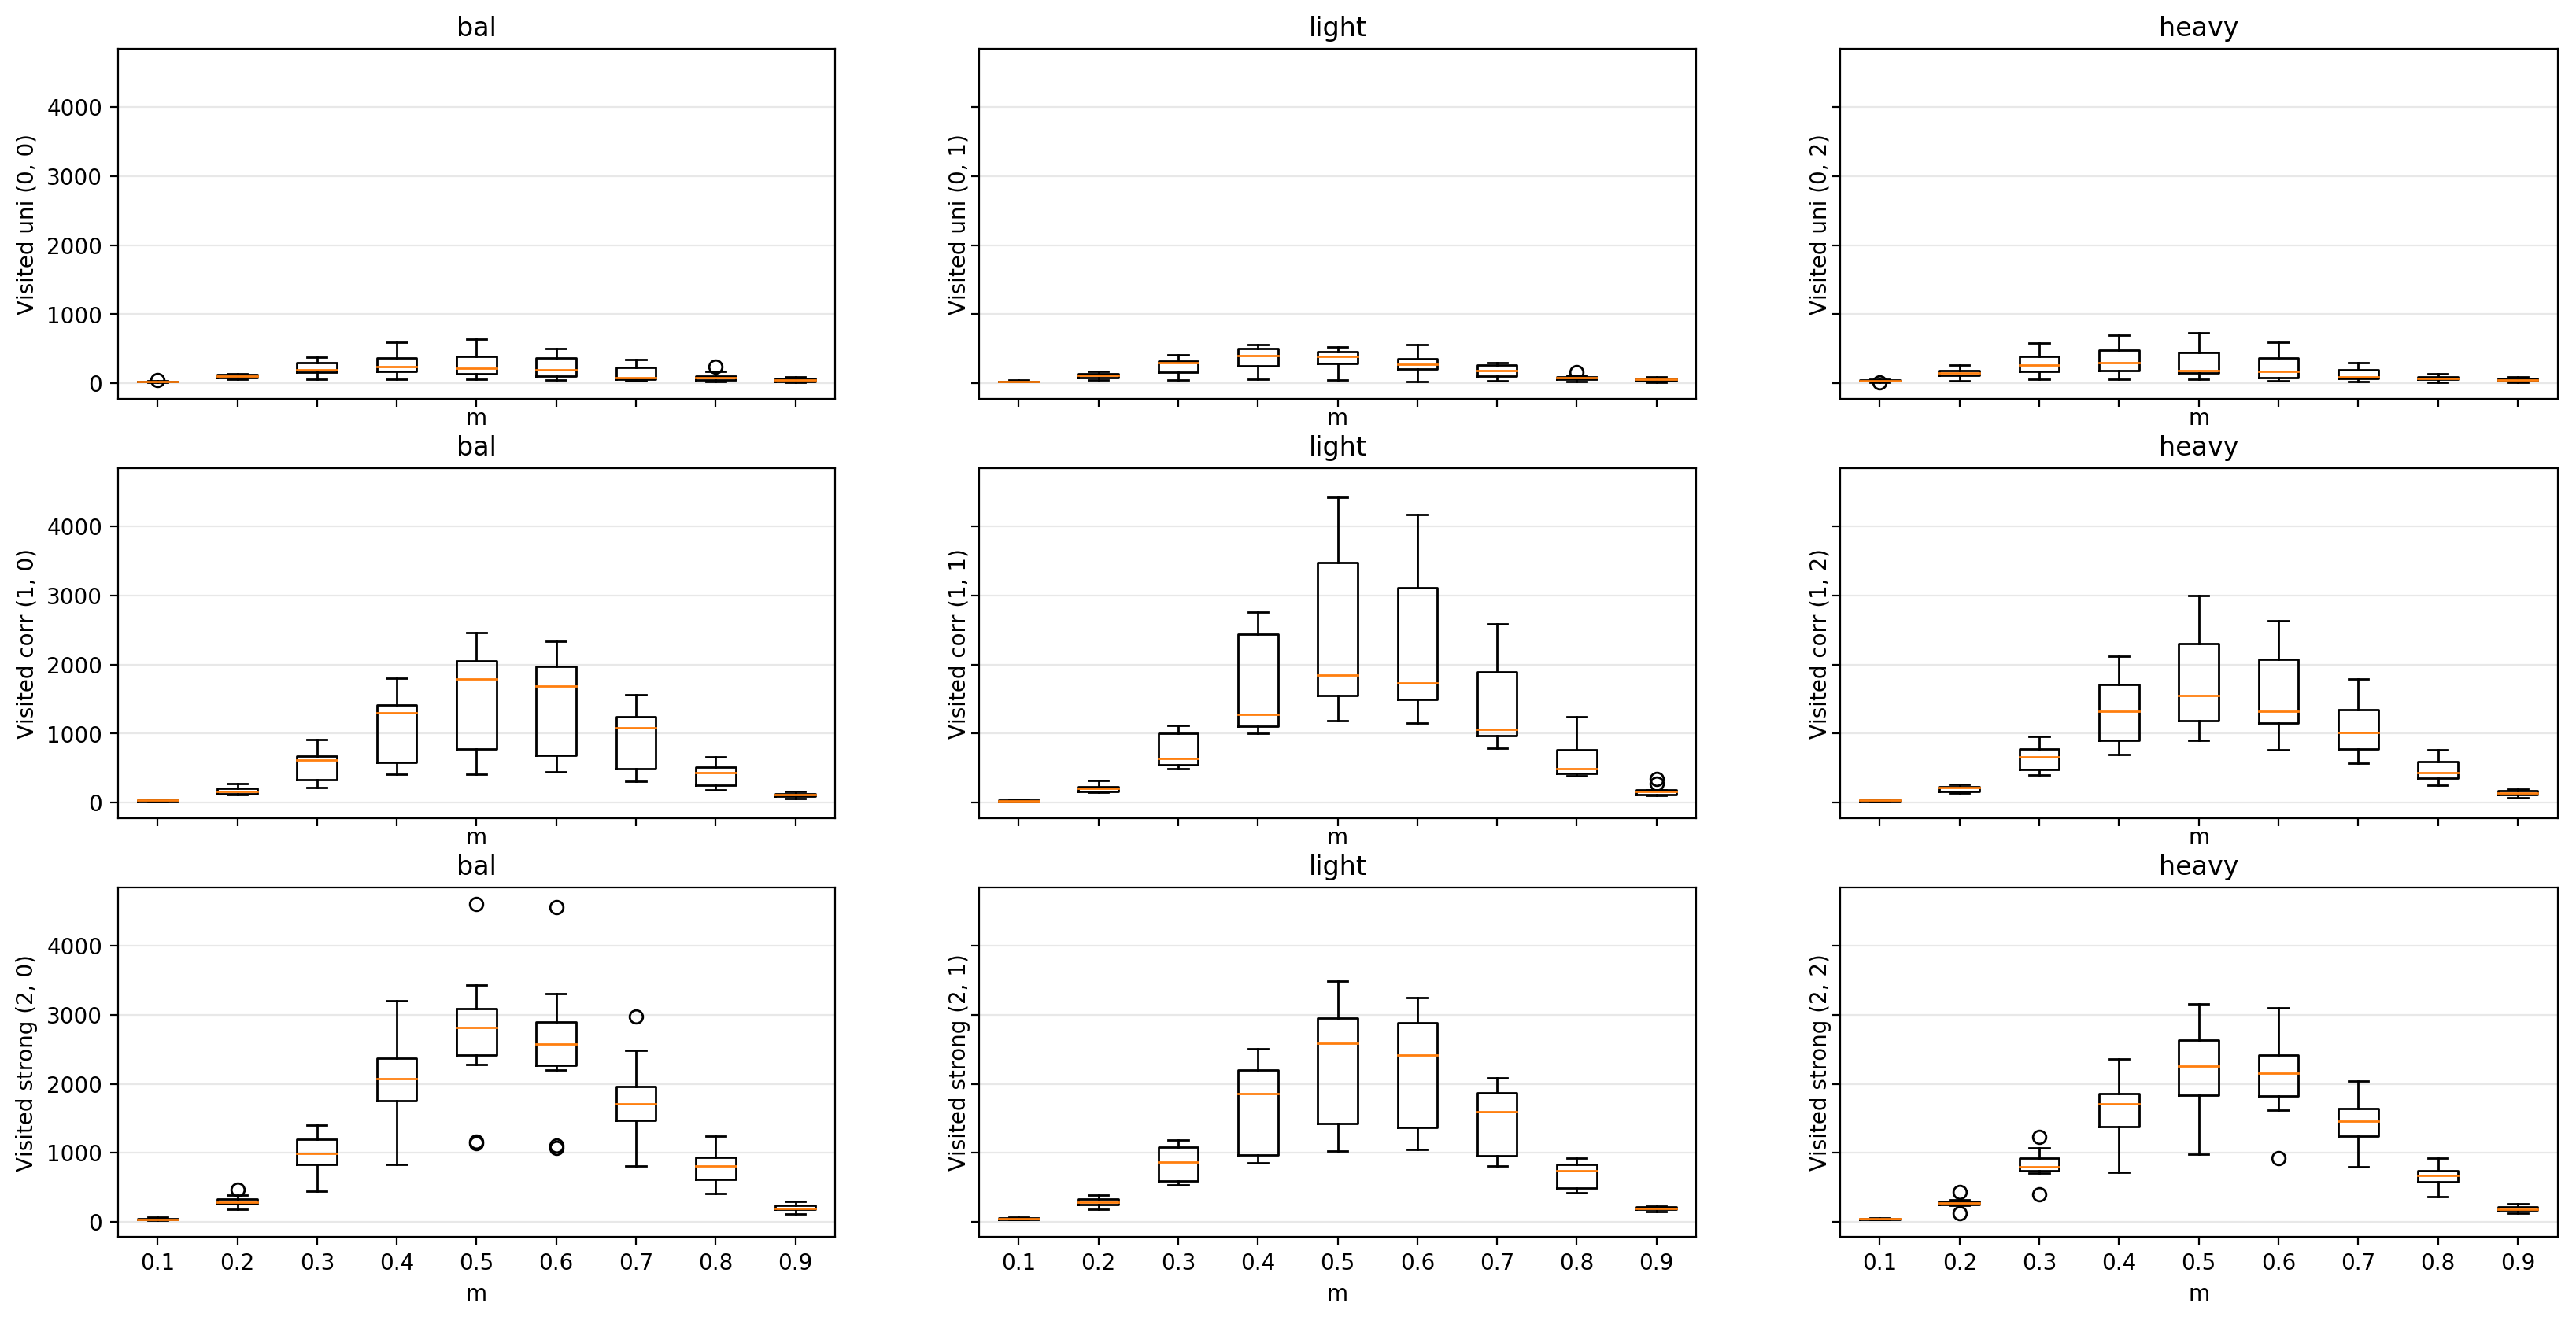

In [375]:
plot_all(15, 10, W, C, ms, 0, S.BranchBound, time=False)

Above I set the parameter `k=0`, so when heavier items are in majority, the correlation coefficient takes its role and rise the number of visited states.

bal; uni, corr, strong, light; uni, corr, strong, heavy; uni, corr, strong, 

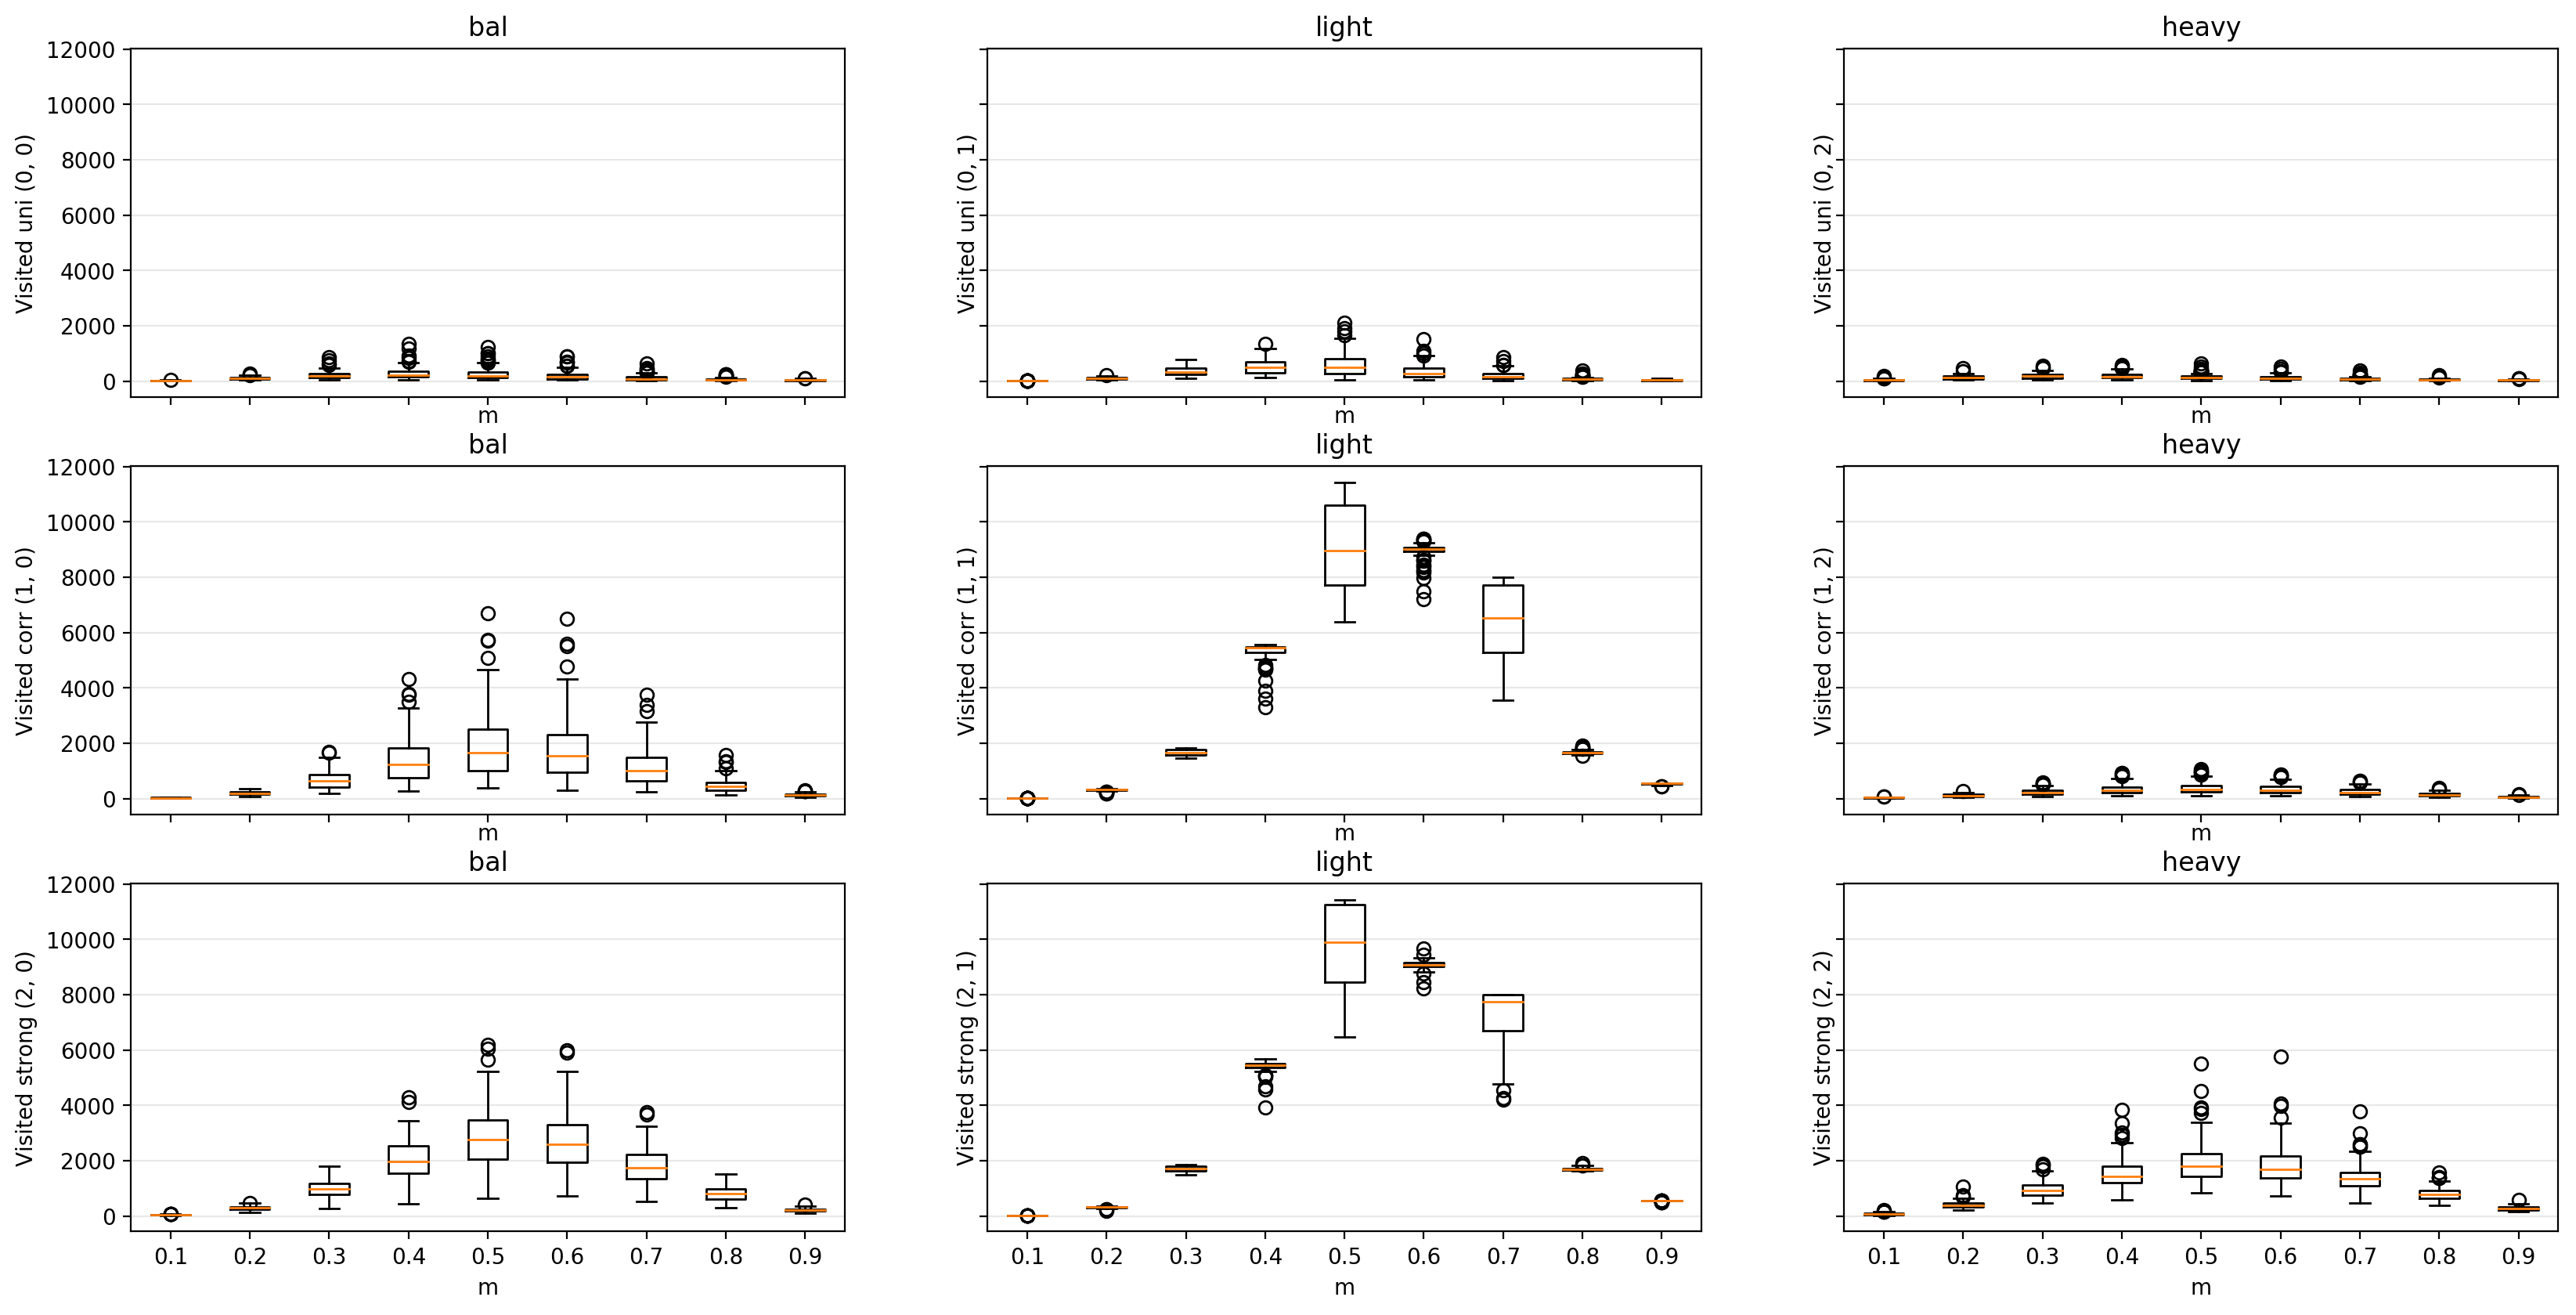

In [377]:
plot_all(n, N, W, C, full_ms, 6, S.BranchBound, time=False)

When changed the parameter `k` to `k=6`, the lighter items are present more frequently, so the algorithm tends to be slower when `m~0.5`.

bal; uni, corr, strong, light; uni, corr, strong, heavy; uni, corr, strong, 

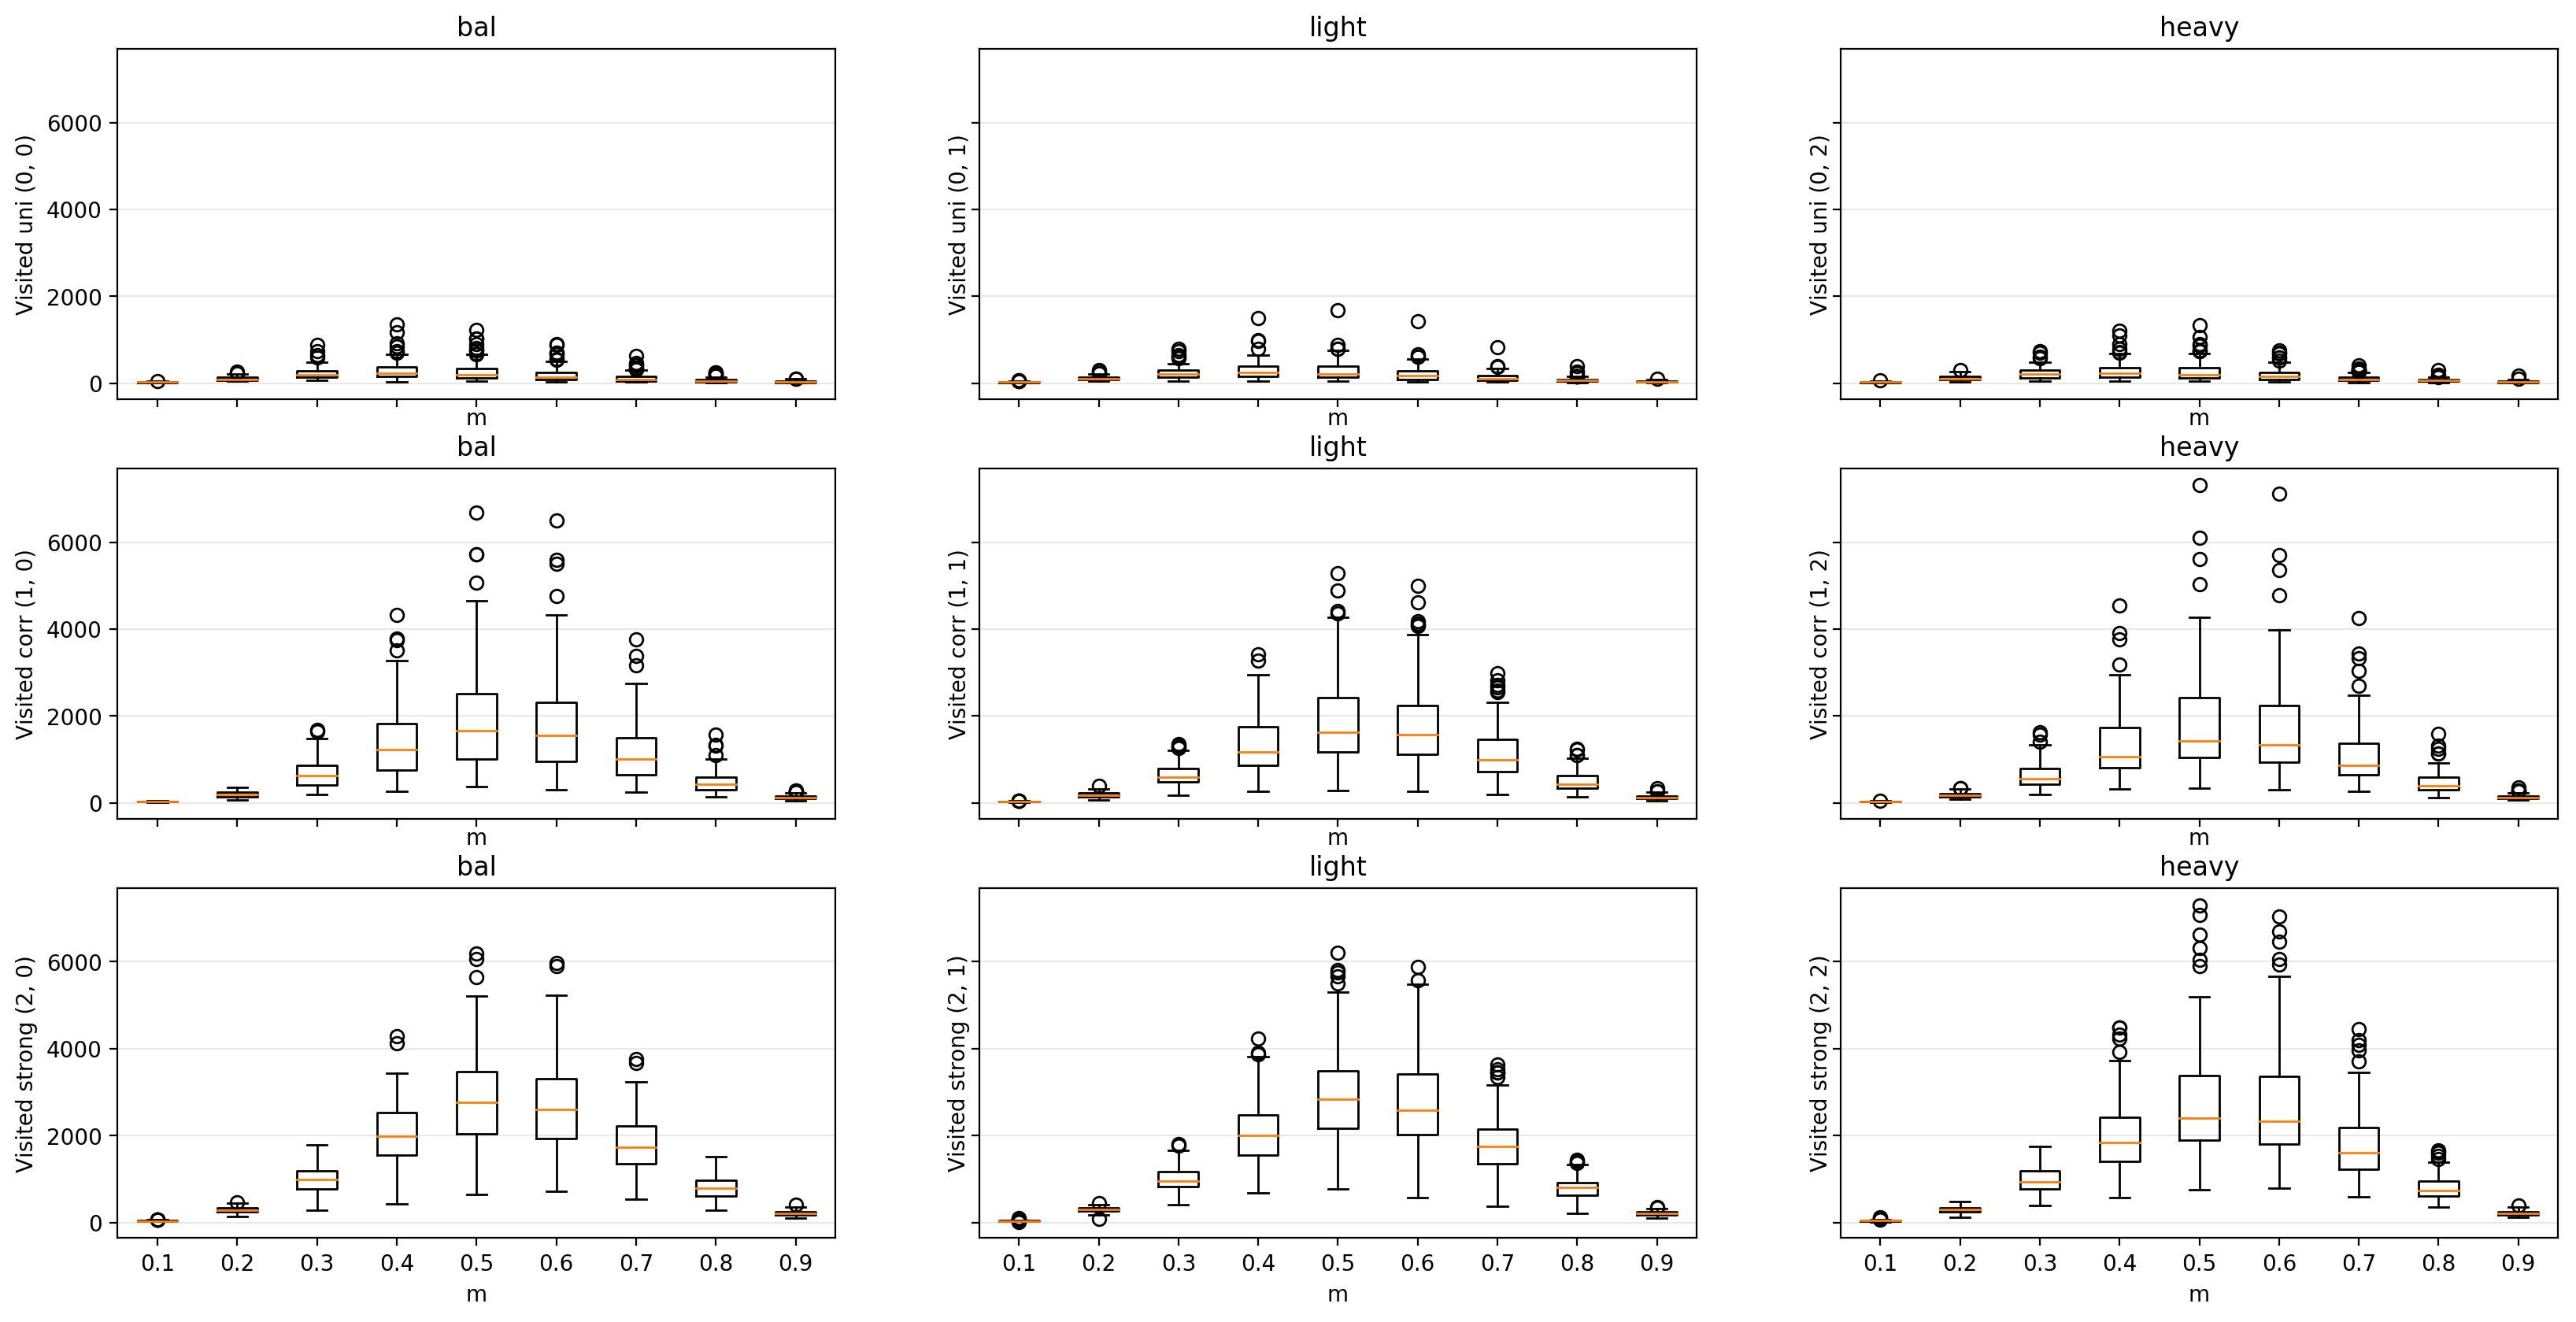

In [378]:
plot_all(n, N, W, C, full_ms, -1, S.BranchBound, time=False)

Above I changed the parameter `k` to -1

bal; uni, corr, strong, light; uni, corr, strong, heavy; uni, corr, strong, 

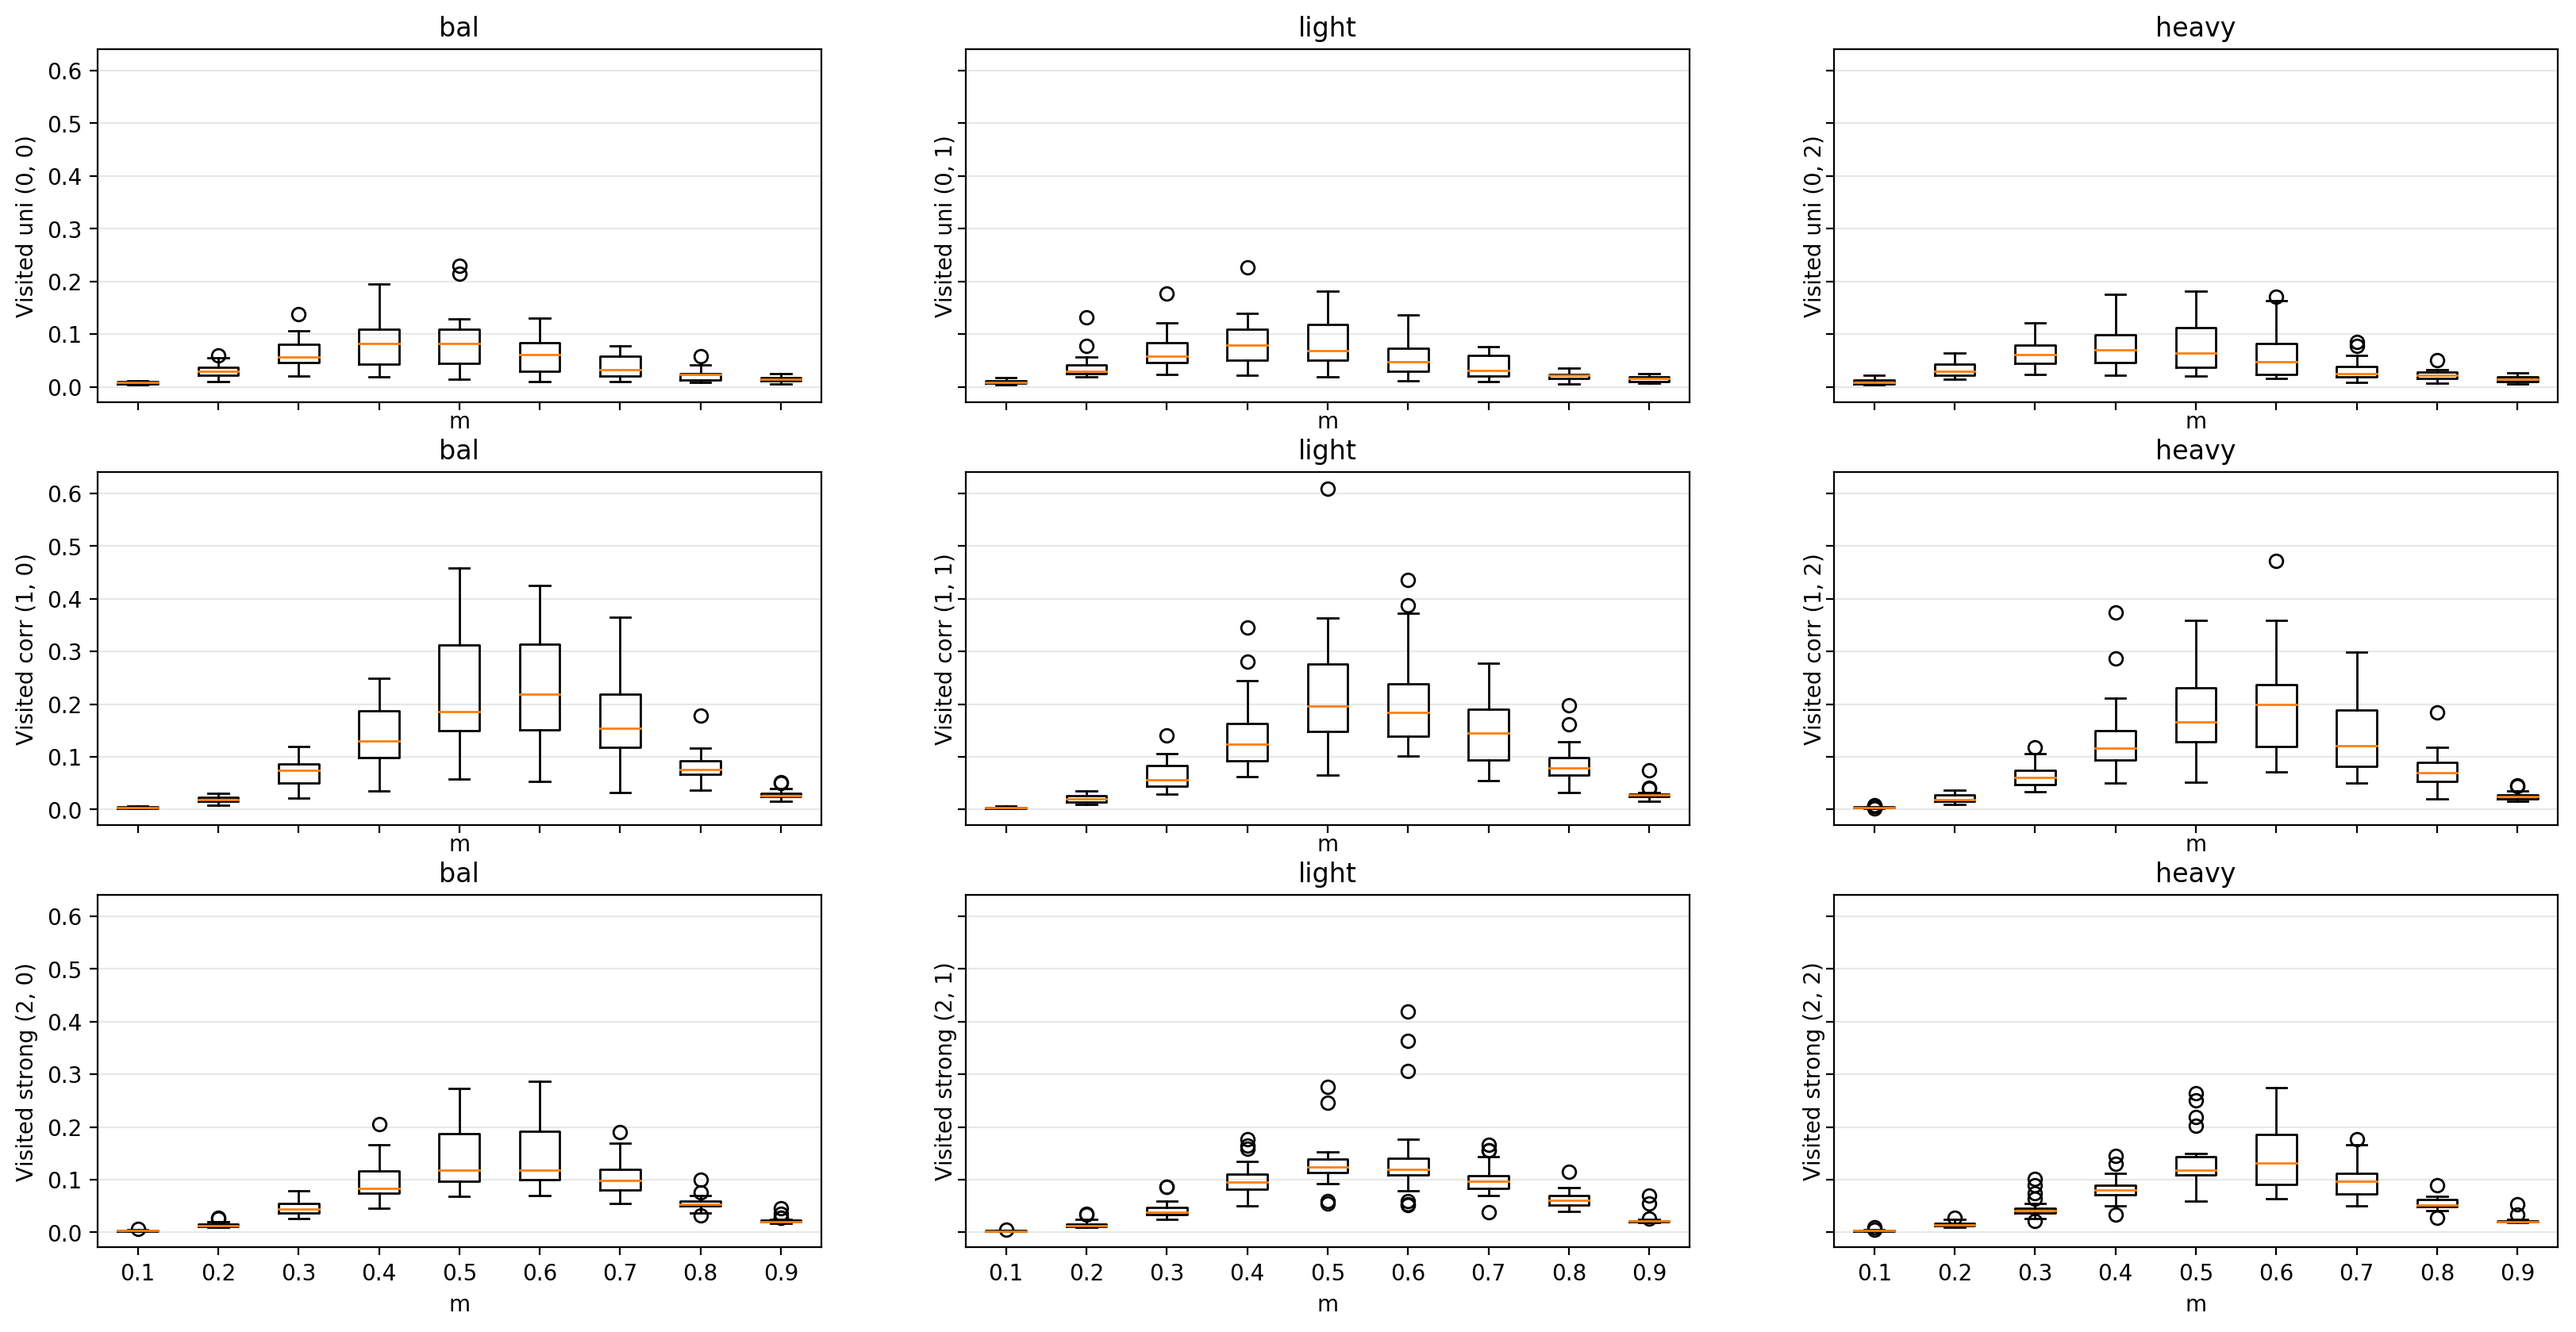

In [379]:
plot_all(n, 25, W, C, full_ms, 0, S.BranchBound, time=True)

Above I also made runtime measurements, to demonstrate the tendency described even more above.

Branch and Bound algorithm doesn't seem to be sensitive to maximal price and weight per instance. 
What is interesting - changing `m` - capacity/sum ratio and a change of different `k`s - granularity.

-  When the input is not correlated at all, it seems to be robust, in terms of granularity.

## Changing k

In [380]:
df = pd.DataFrame()
for k in np.linspace(-2, 2, 9):
    df[str(k)] = solve_instances(generate(n, 50, W, C, 0.6, 'light', 'corr', k), S.BranchBound, False)

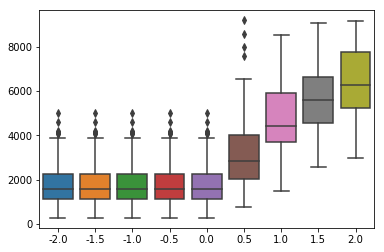

In [381]:
import seaborn as sns
sns.boxplot(data=df)
# print(df)

the parameters are: `n=15, N=50, W=500, C=500, m=0.6, w='light', c='corr'`
When increasing the `k` parameter, the complexity is rising.

In [398]:
df = pd.DataFrame()
for k in np.linspace(-2, 2, 9):
    df[str(k)] = solve_instances(generate(15, 50, W, C, 0.6, 'heavy', 'strong', k), S.BranchBound, False)

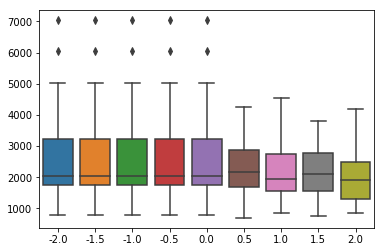

In [399]:
sns.boxplot(data=df)

Same parameters as one graph above, but having set `w='heavy'`. This is the opposite tendency.


## `m` as an interval

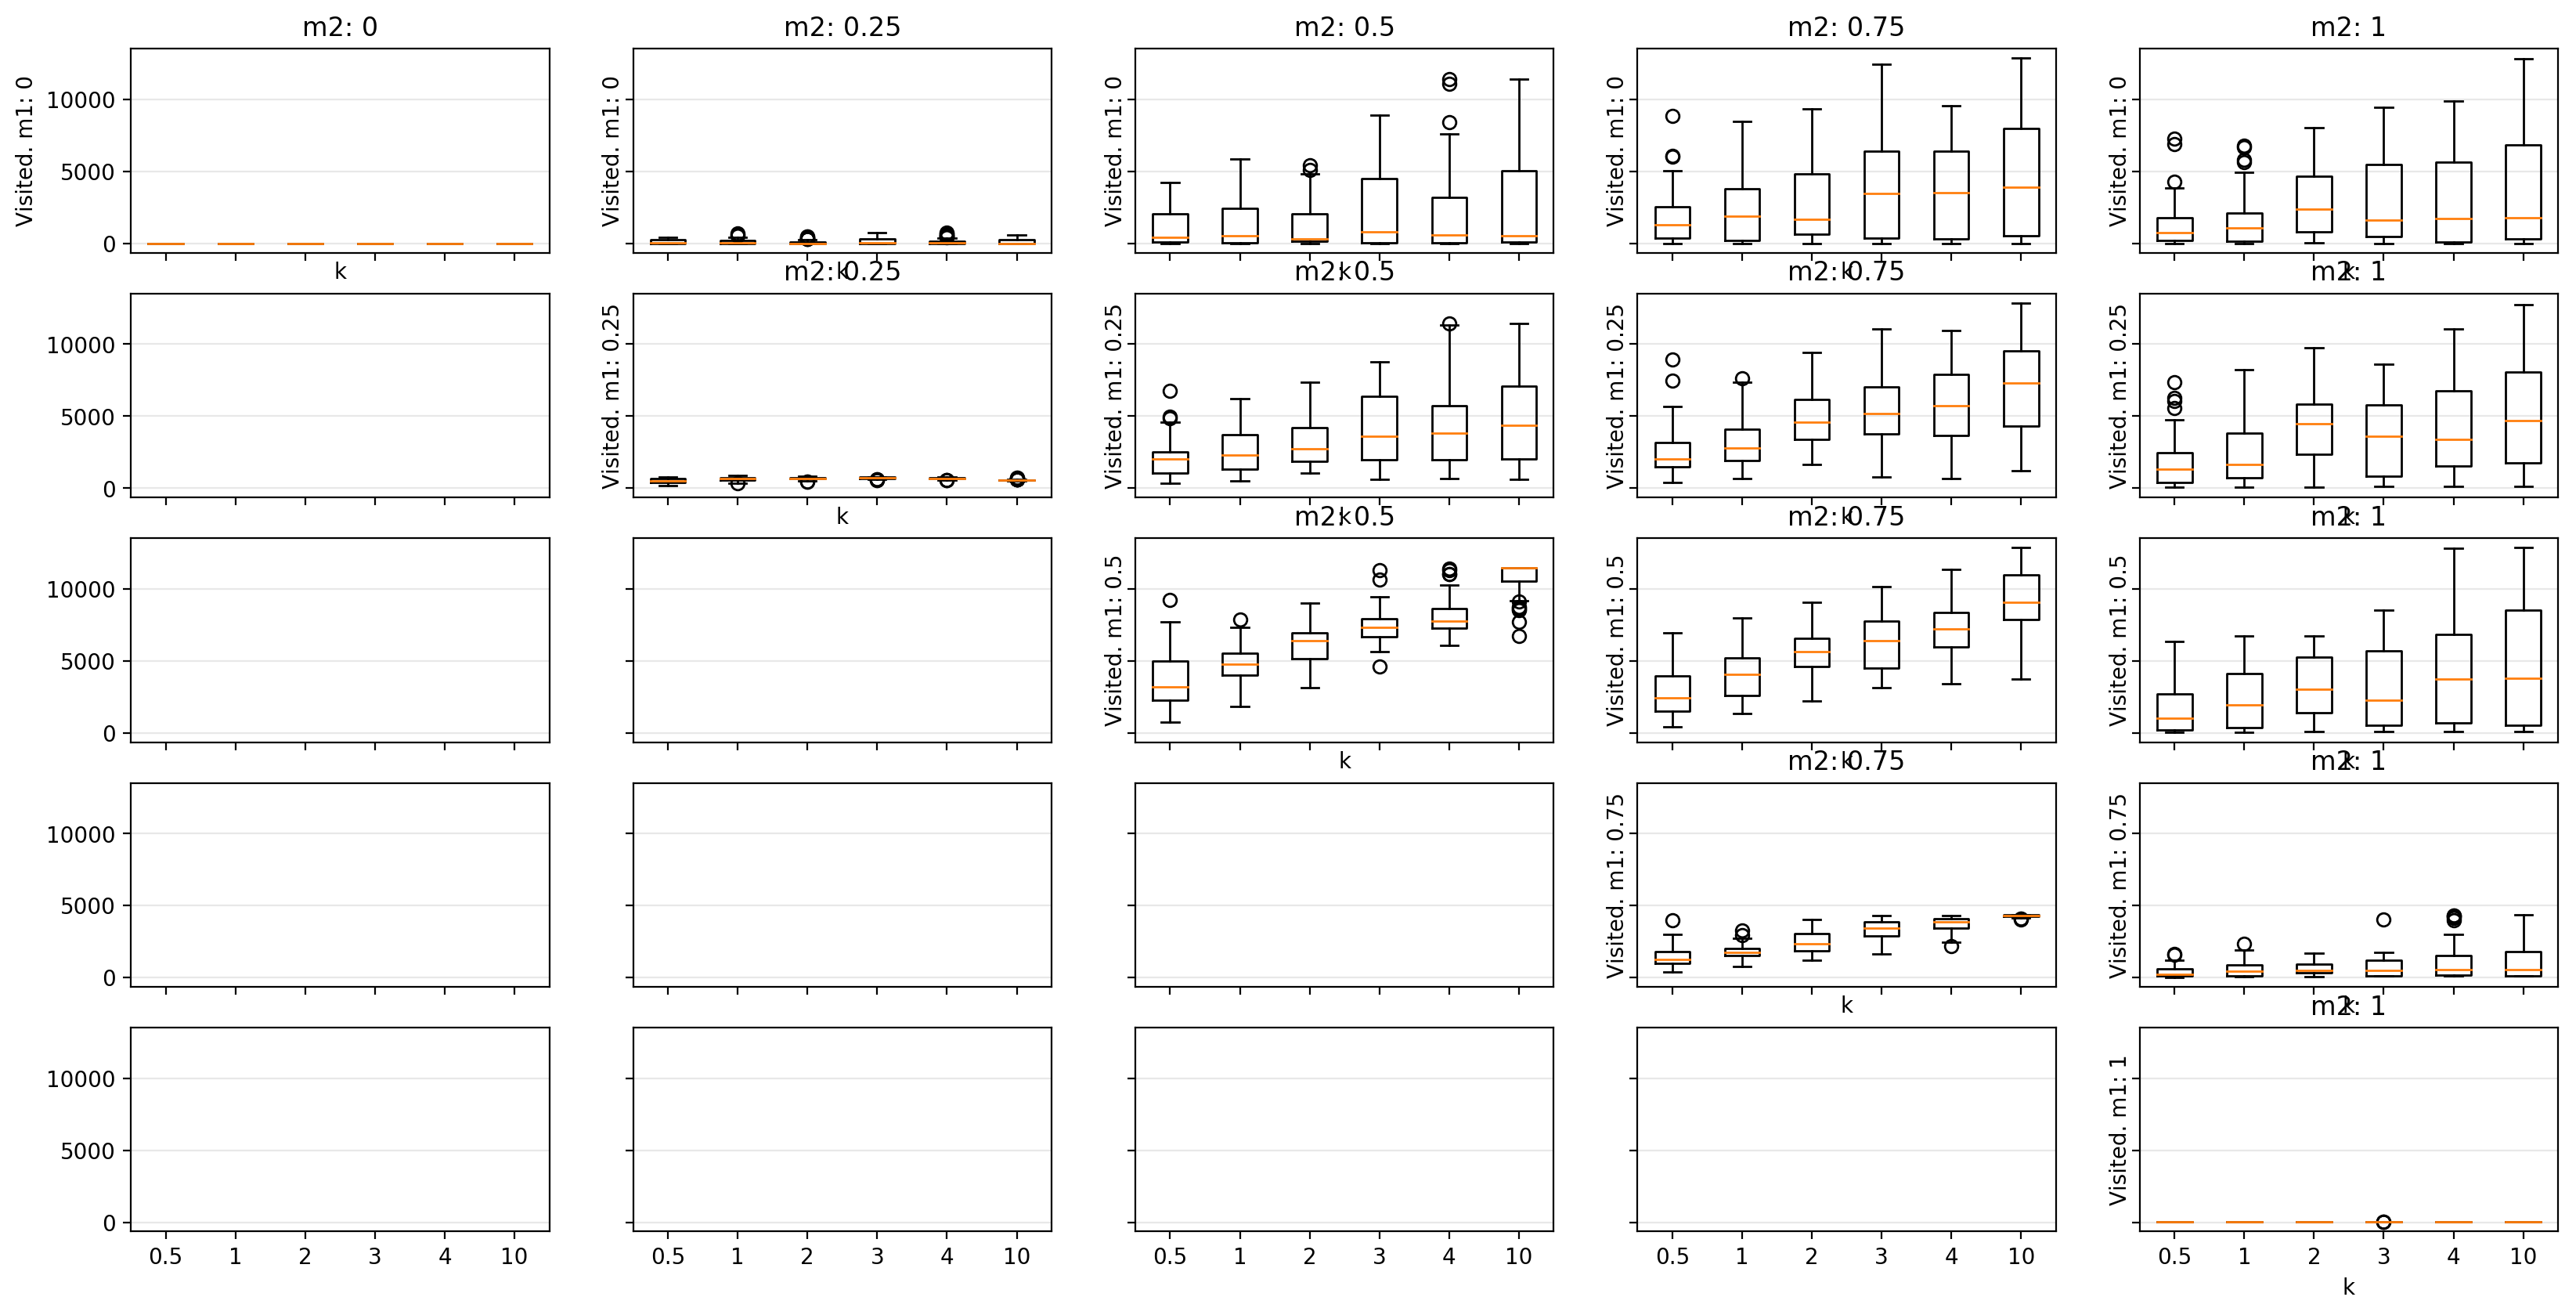

In [64]:
fig, axs = plt.subplots(5, 5, sharey=True, sharex=True, figsize=(20, 10), dpi=200)
for (x,y), value in np.ndenumerate(axs):
    axs[x,y].yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

ms = [0, 0.25, 0.5, 0.75, 1]
ks = [0.5, 1, 2, 3, 4, 10]
    
for m1 in range(len(ms)):

    for m2 in range(m1, len(ms)):
        df = pd.DataFrame()
        for k in ks:
            df[str(k)] = solve_instances(generate(n, 50, W, C, (ms[m1], ms[m2]), 'light', 'corr', k), S.BranchBound, False)
        ax = axs[m1, m2]
        ax.boxplot(df.values)
        title = "m2: " + str(ms[m2])
        ax.set_title(title)
        ax.set_ylabel(str("Visited. m1: " + str(ms[m1])))
        ax.set_xlabel("k")
        ax.set_xticklabels(ks)


when having the parameter `m` as an interval, the complexity is not changing much.

## `m` more precisely

In [469]:
ms = np.linspace(0.4, 0.8, num=15)
df = pd.DataFrame()
for m in ms:
    input_lines = generate(15, 100, W, C, m, 'light', 'corr', 100)
    df[str(m)] = solve_instances(input_lines, S.BranchBound, False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

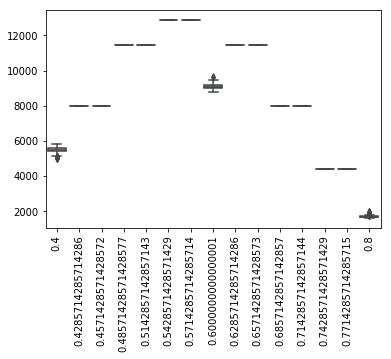

In [470]:
sns.boxplot(data=df)
plt.xticks(rotation='vertical')

Here I tried to create the most complex input for the BnB. Still it makes at most half of the states possible.

Above - x-axis is different m, y is nr. of visited states.

## Robustness

In [499]:
stdin = generate(6, 1, 100, 100, 0.4, 'bal', 'uni', 1)
result = solve_instances(permute(1, math.factorial(6), '\n'.join(stdin)), S.BranchBound, False)

In [503]:
dd = pd.DataFrame(result)
print("std: ", dd.std())
print("mean: ", dd.mean())

std:  0    0.0
dtype: float64
mean:  0    9.0
dtype: float64


I am sorting the input in my implementation of BnB, therefore this algorithm is robust.

# Dynamic Programming - by weight
# Sensitivity

In [512]:
def plot_dp(n, N, Ws, Cs, ms, w, c, k, solver, time=True):
    fig, axs = plt.subplots(len(Cs), len(Ws), sharey=True, sharex=True, figsize=(20, 20), dpi=200)
    for (x,y), value in np.ndenumerate(axs):
        axs[x,y].yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

    for col in range(len(Ws)):
        print(Ws[col], end='; ')
        for row in range(len(Cs)):
            print(Cs[row], end=', ')
            df = pd.DataFrame()
            for m in ms:
#                 print((n, N, Ws[col], Cs[row], m, w, c, k))
                input_lines = generate(n, N, Ws[col], Cs[row], m, w, c, k)
#                 print(input_lines)
                df[str(m)] = solve_instances(input_lines, solver, time)
#             print(df)
            ax = axs[row, col]
            ax.boxplot(df.values)
            ax.set_title("Max Weight: " + str(Ws[col]))
            ax.set_ylabel("Time. Price: " + str(Cs[row]))
            ax.set_xlabel("m")
            ax.set_xticklabels(ms)

In [9]:
Ws = np.linspace(100, 1000, 4, dtype=int)
# Cs = np.linspace(100, 1000, 4, dtype=int)
Cs = np.linspace(100, 1000, 4, dtype=int)

100; 100, 200, 400; 100, 200, 700; 100, 200, 1000; 100, 200, 

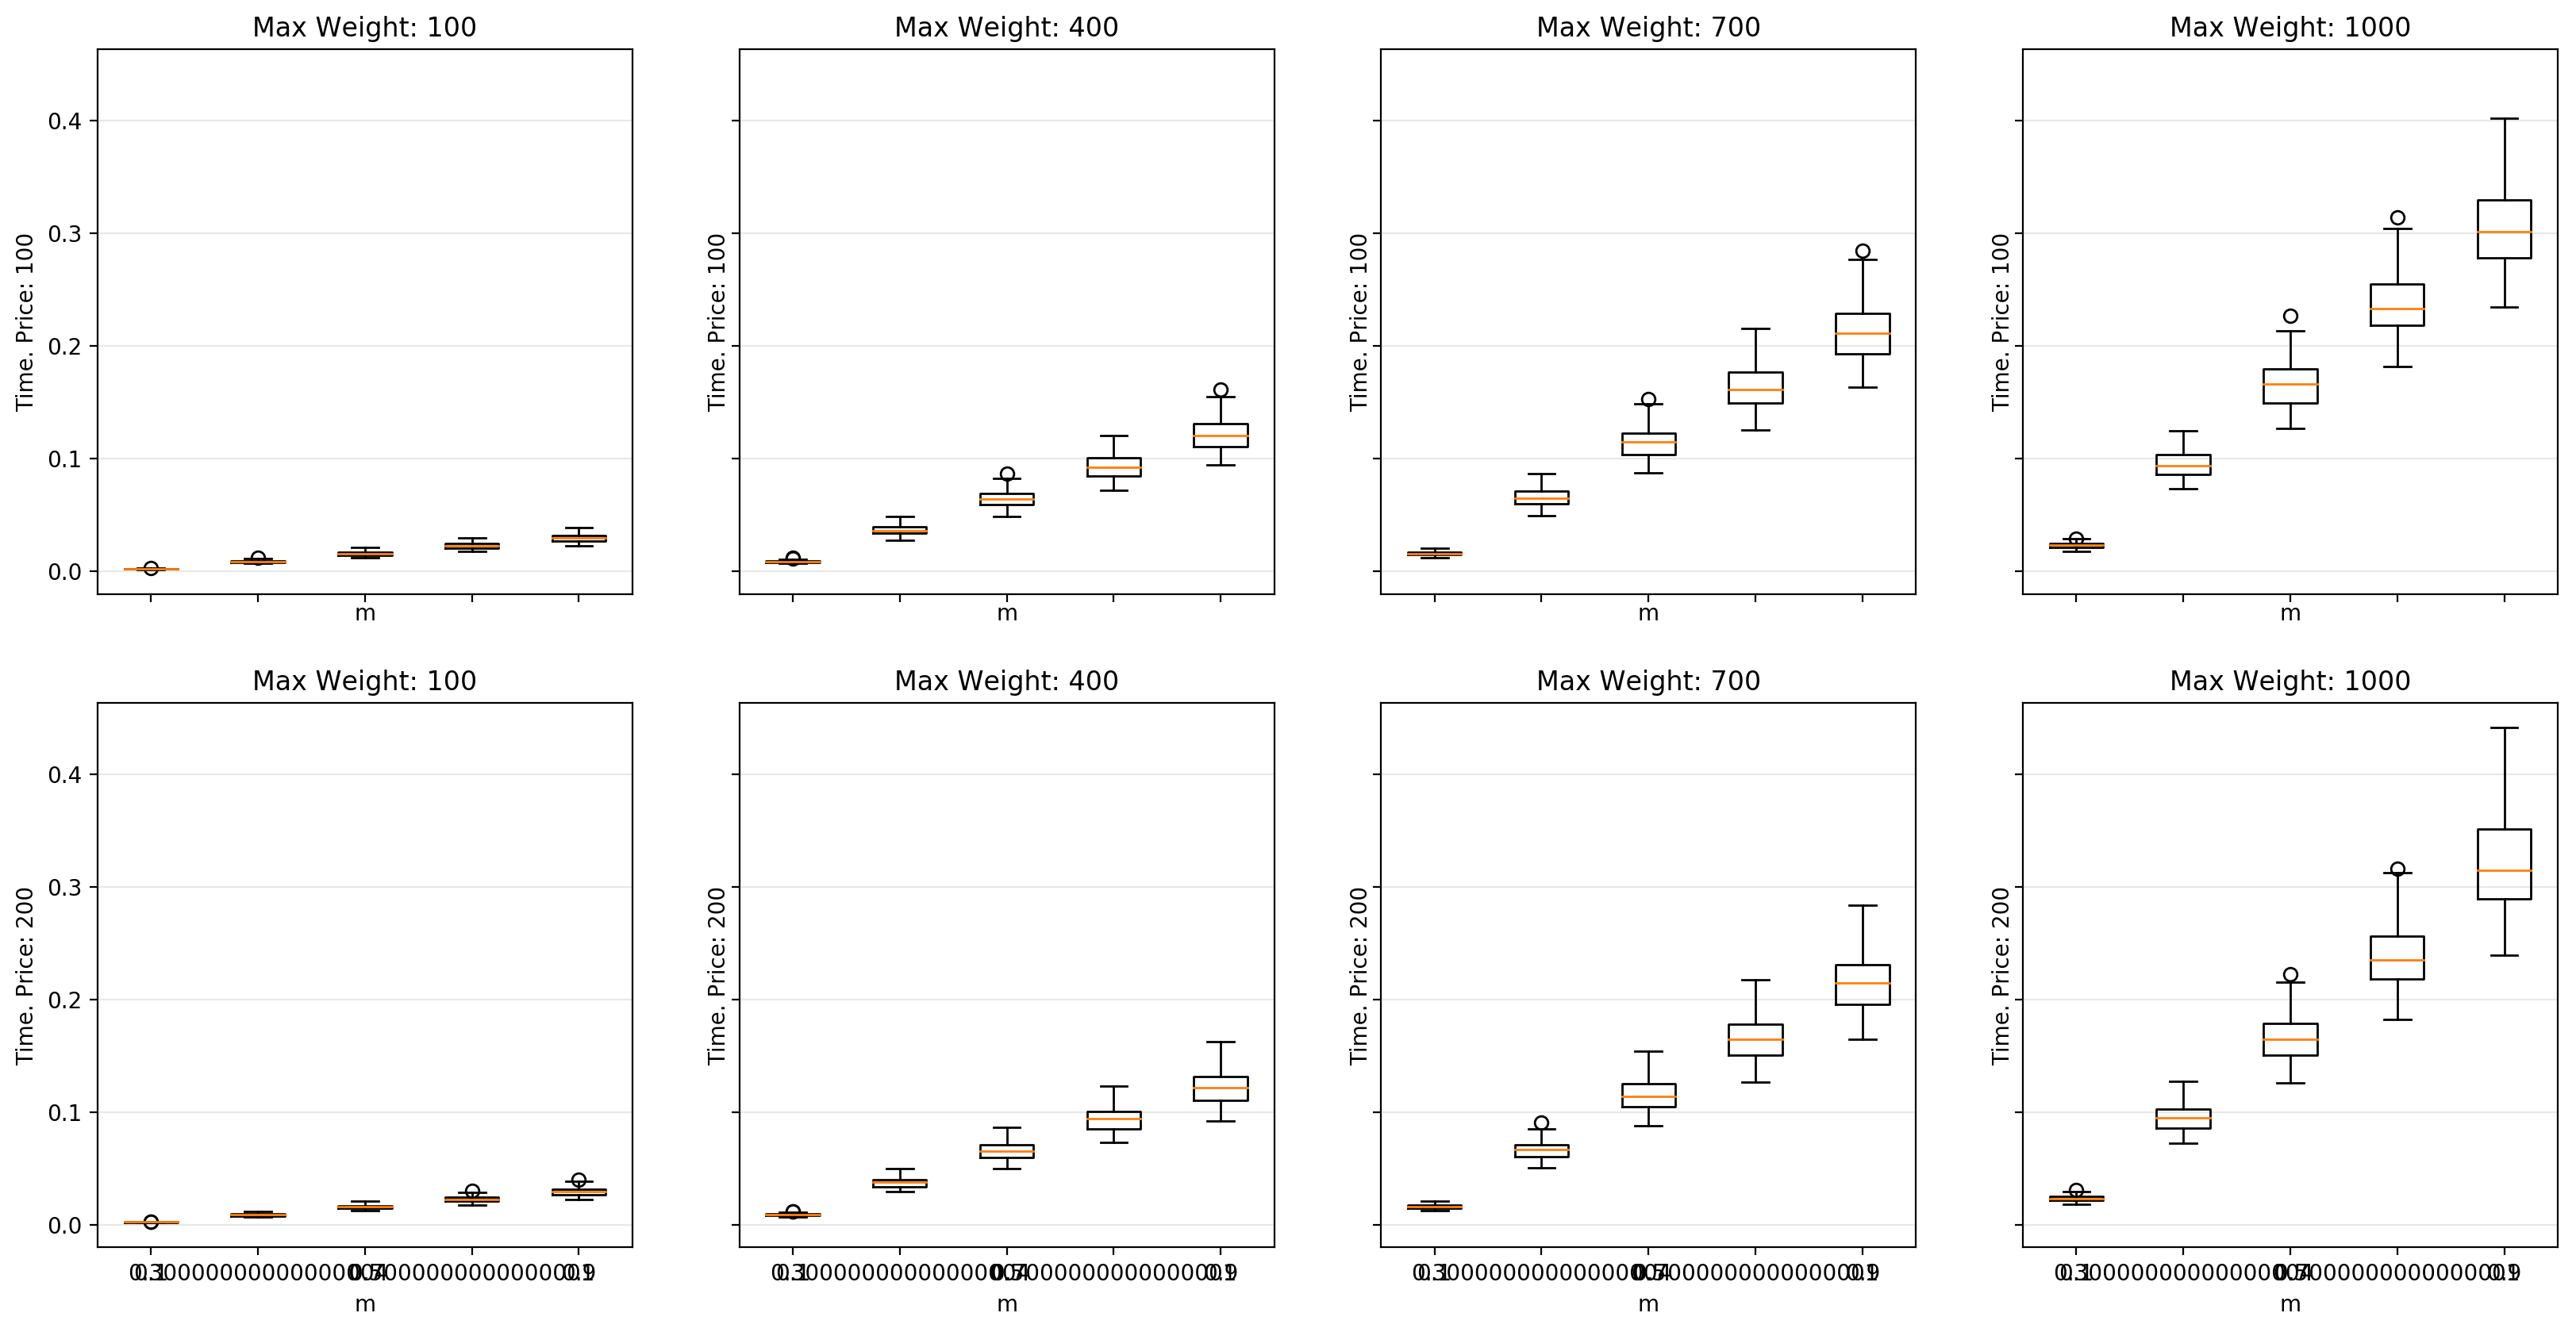

In [457]:
plot_dp(15, 50, Ws, Cs, np.linspace(0.1, 0.9, 5), 'bal', 'uni', 0, S.DPIterative, time=True)

Sorry for bad rendering. `m` values are: (0.1, 0.3, 0.5, 0.7, 0.9).

We can see how different `m` is changing the complexity of DP algorithm. As expected, different maximal price does not affect the complexity. Just the weight.

It depends on how many heavy items we are able to put to backpack, therefore if increasing the `m` parameter, we see how the complexity rises.


bal; uni, corr, strong, light; uni, corr, strong, heavy; uni, corr, strong, 

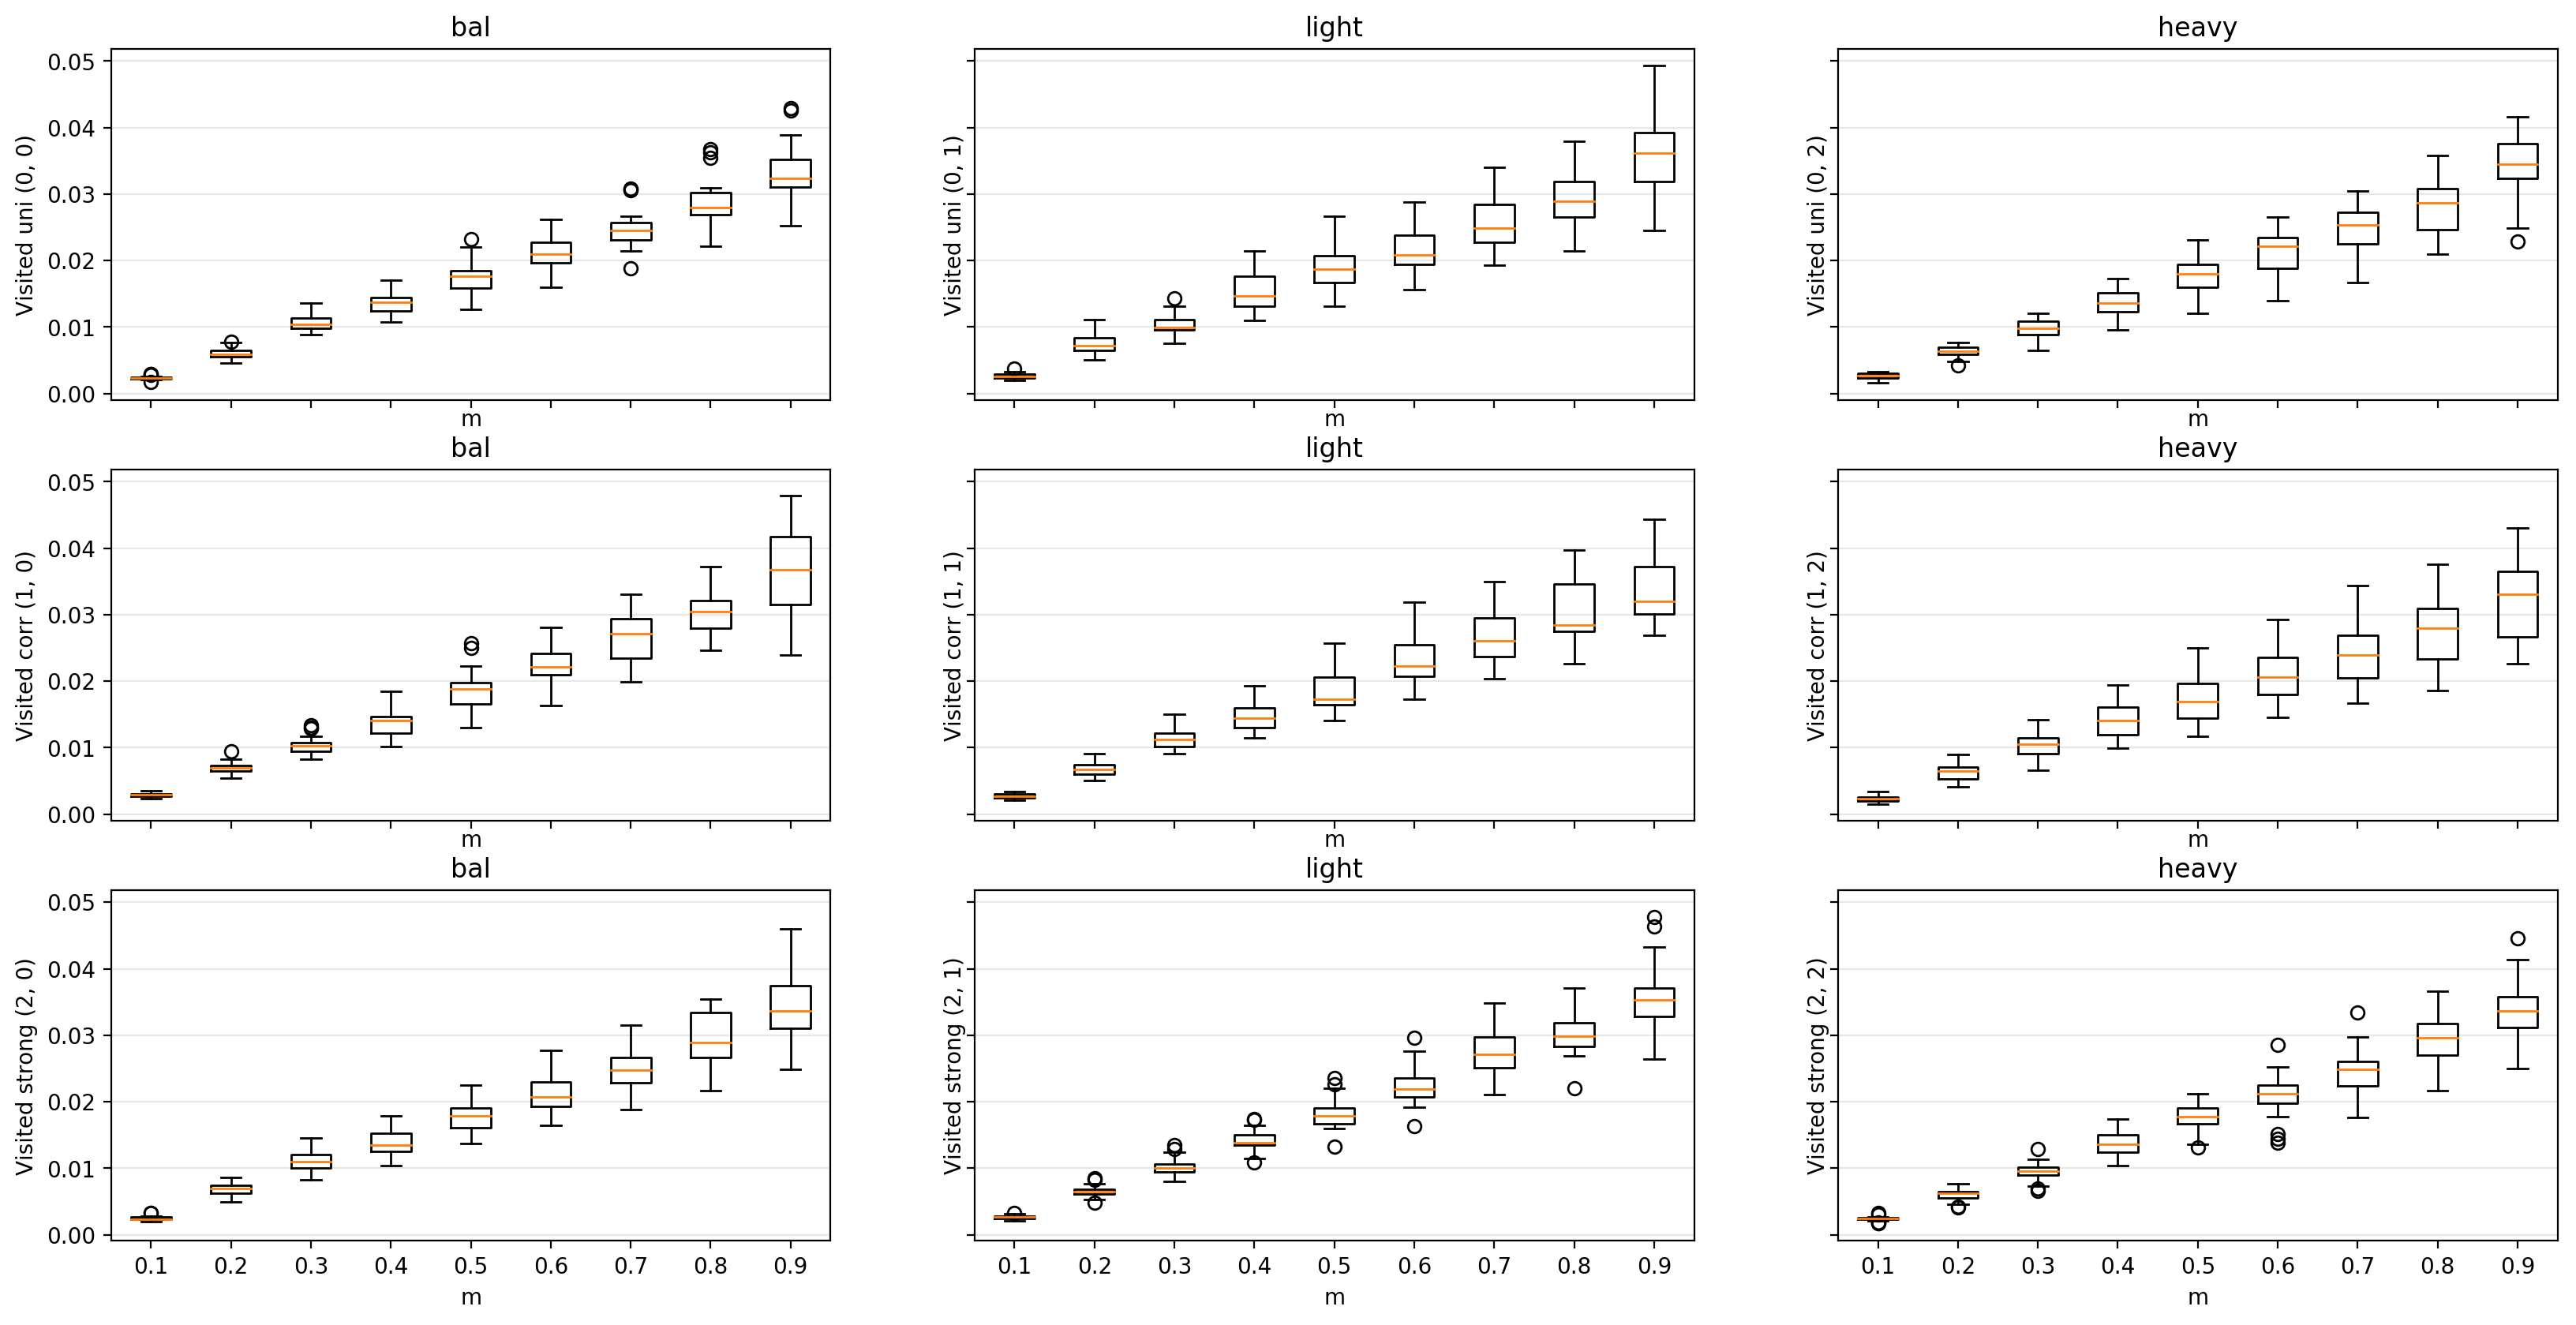

In [460]:
plot_all(n, 25, 100, 100, full_ms, 0, S.DPIterative, time=True)

Parameters `w` and `c` does not affect the complexity.

y-axis is NOT visited states, but time, since the table is determined by the input.

In [462]:
df = pd.DataFrame()
for k in np.linspace(-2, 2, 9):
    df[str(k)] = solve_instances(generate(n, 25, 100, 100, 0.5, 'light', 'corr', k), S.DPIterative, True)
    

Text(0.5, 1.0, "n, N=25, W=100, C=100, m=0.5, w='light', c='corr', k")

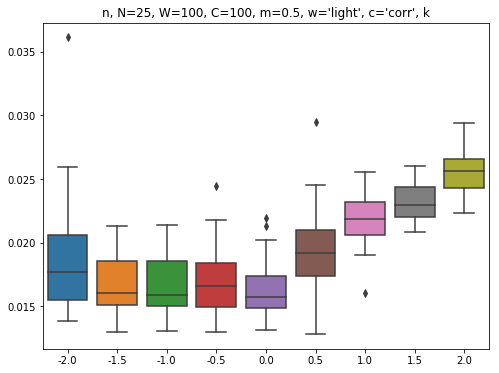

In [468]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df)
plt.title("n, N=25, W=100, C=100, m=0.5, w='light', c='corr', k")

Boosting the probability of occurence of heavy items by increasing the `k` parameter, we can see that the complexity is rising.

x-axis is various `k` parameter

## Robustness


In [529]:
stdin = generate(7, 1, 50, 50, 0.4, 'bal', 'uni', 1)
permutation = permute(1, math.factorial(7), '\n'.join(stdin))
print(permutation[:10], end="\n")
result = pd.DataFrame(solve_instances(permutation, S.DPIterative, True))
print(result.mean())
print(result.std())

['2 7 54 36 39 13 38 39 11 13 45 10 12 18 20 8 9', '3 7 54 39 11 13 45 36 39 13 38 8 9 18 20 10 12', '4 7 54 13 45 10 12 39 11 18 20 8 9 36 39 13 38', '5 7 54 13 45 13 38 10 12 36 39 18 20 39 11 8 9', '6 7 54 18 20 39 11 13 45 10 12 8 9 36 39 13 38', '7 7 54 10 12 18 20 39 11 36 39 8 9 13 45 13 38', '8 7 54 13 38 39 11 36 39 8 9 18 20 10 12 13 45', '9 7 54 10 12 36 39 13 45 8 9 18 20 13 38 39 11', '10 7 54 13 45 39 11 8 9 10 12 36 39 18 20 13 38', '11 7 54 10 12 36 39 18 20 39 11 13 38 13 45 8 9']
0    0.001049
dtype: float64
0    0.000058
dtype: float64


This algorithm is very robust, because even if not sorting the input, I still make the same memoization table, so permuting has no effect.

# Dynamic Programming - decomposition by price
# Sensitivity

100; 100, 400, 700, 1000, 200; 100, 400, 700, 1000, 

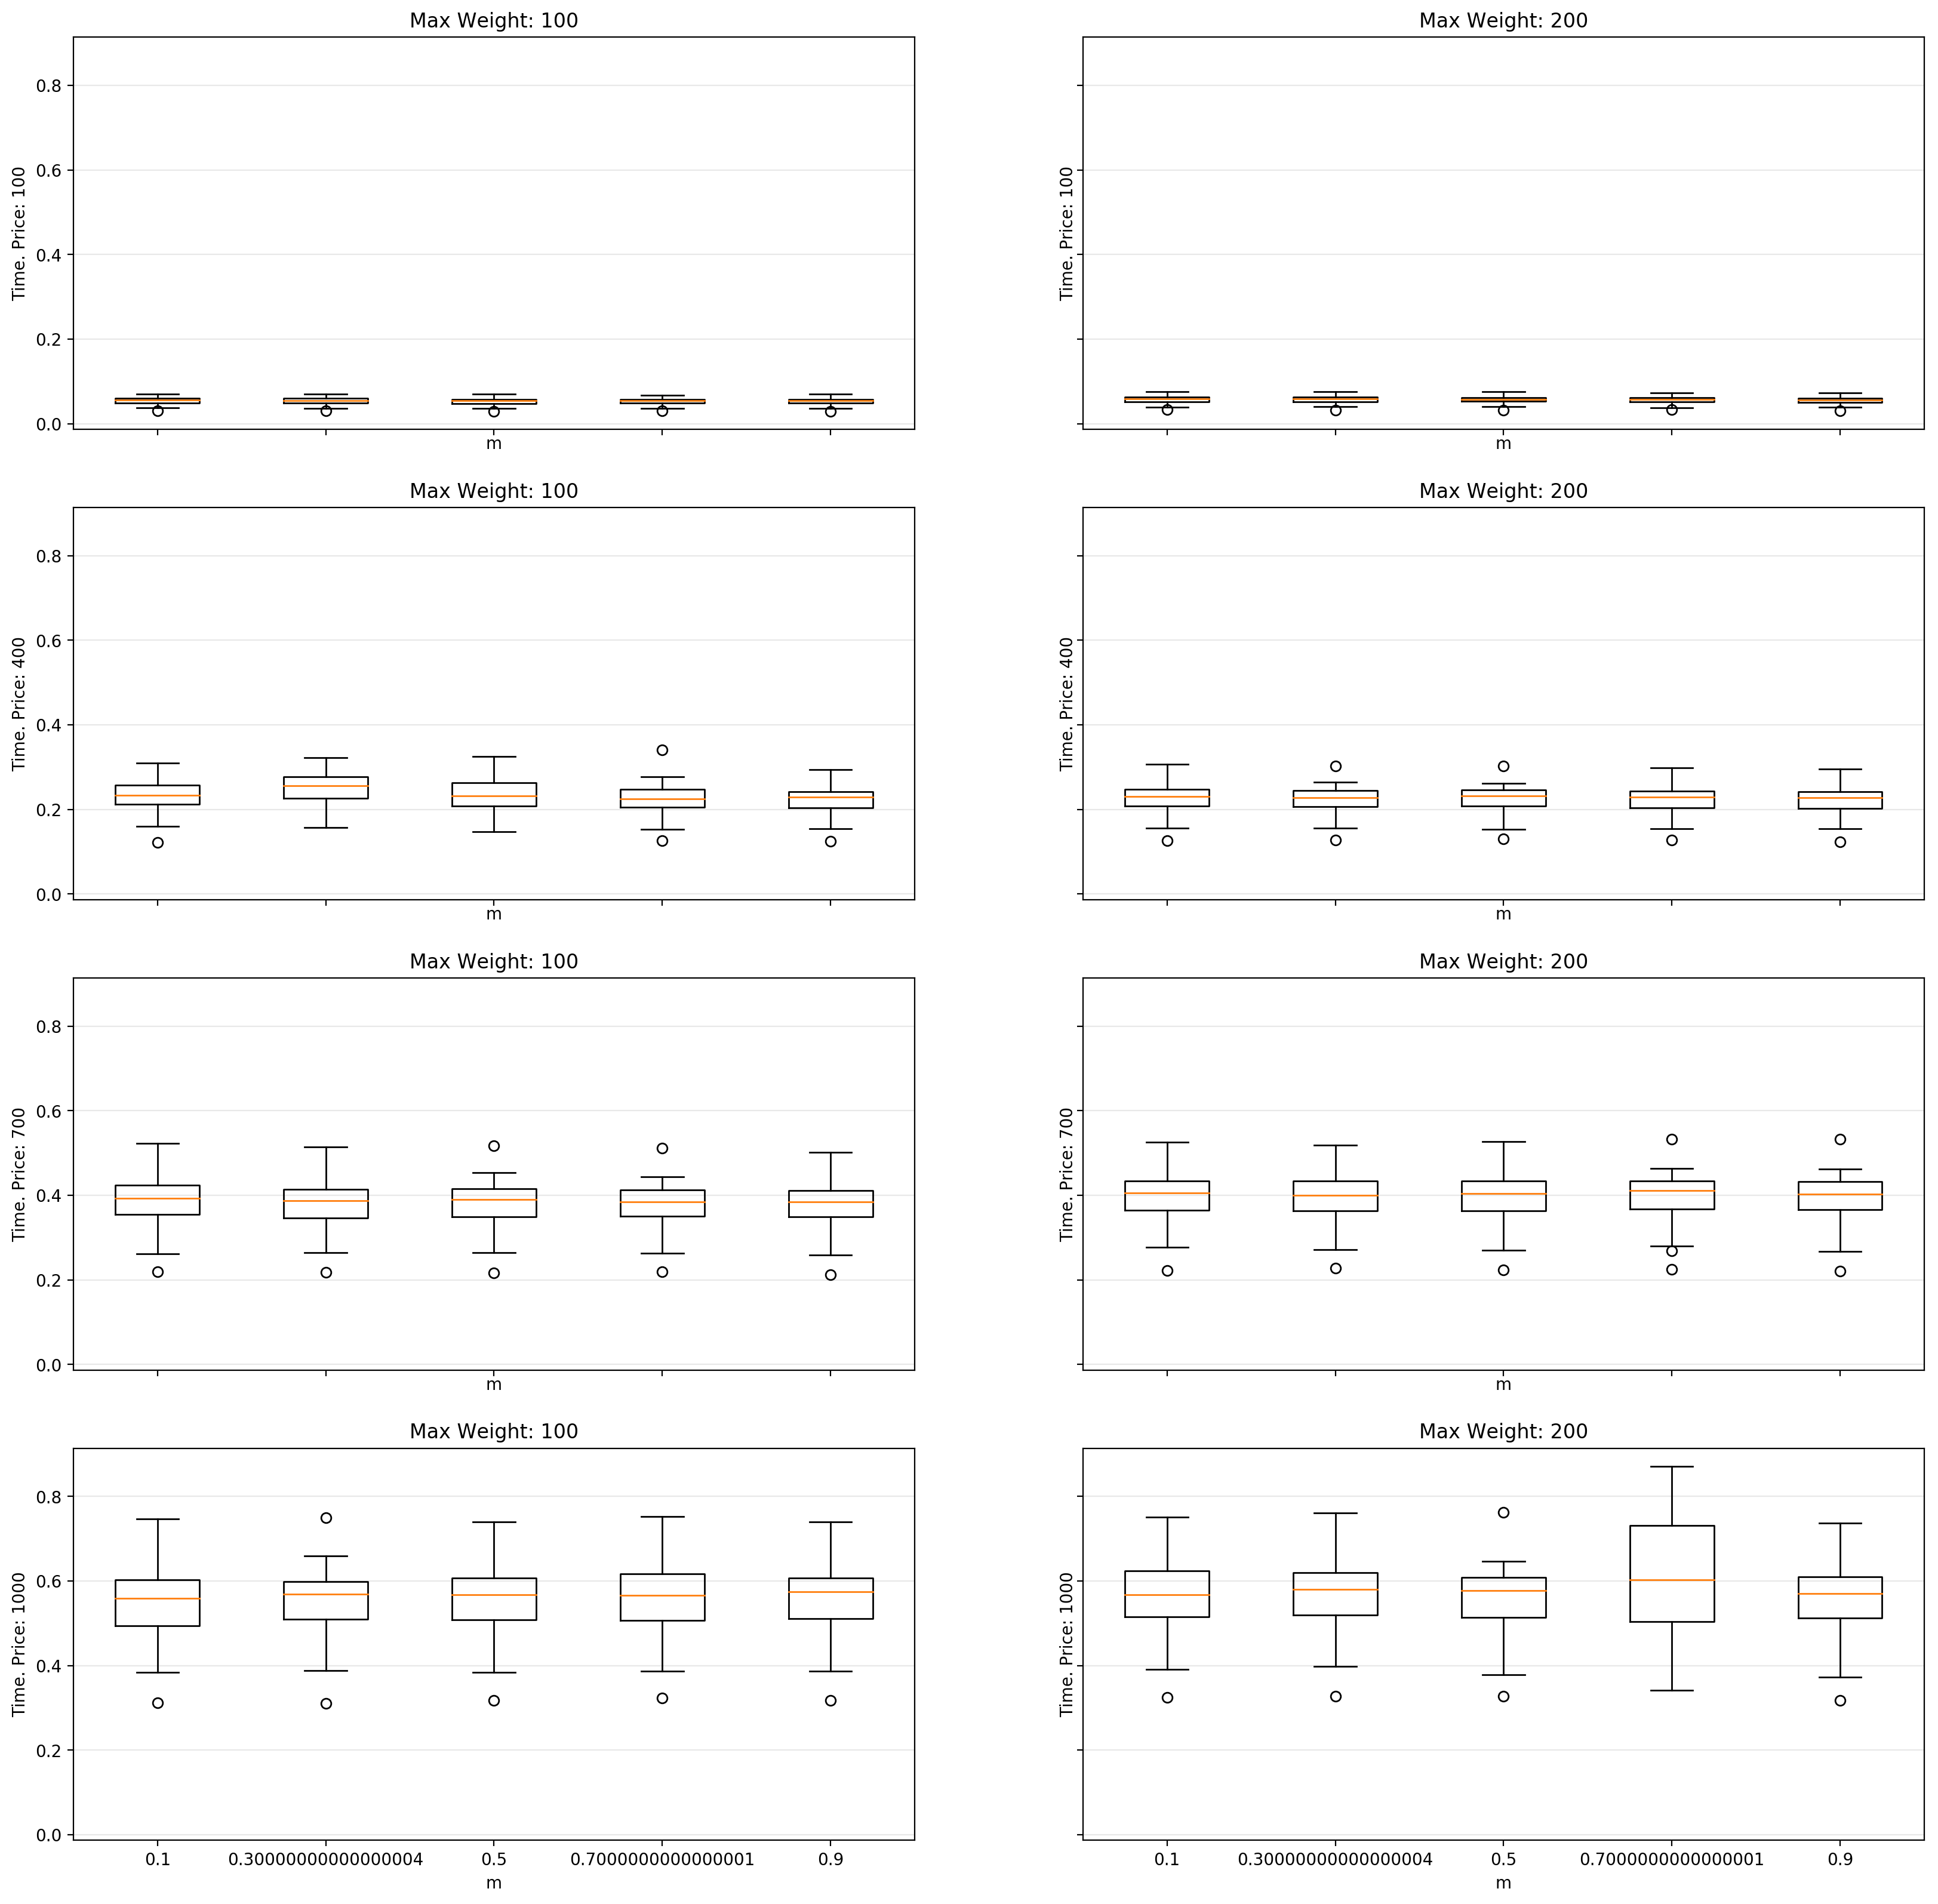

In [517]:
Ws = [100, 200]
Cs = np.linspace(100, 1000, 4, dtype=int)

plot_dp(15, 20, Ws, Cs, np.linspace(0.1, 0.9, 5), 'bal', 'uni', 1, S.DPIterativeByPrice, time=True)

as expected, time is rising, when maximum price is higher.

bal; uni, corr, strong, light; uni, corr, strong, heavy; uni, corr, strong, 

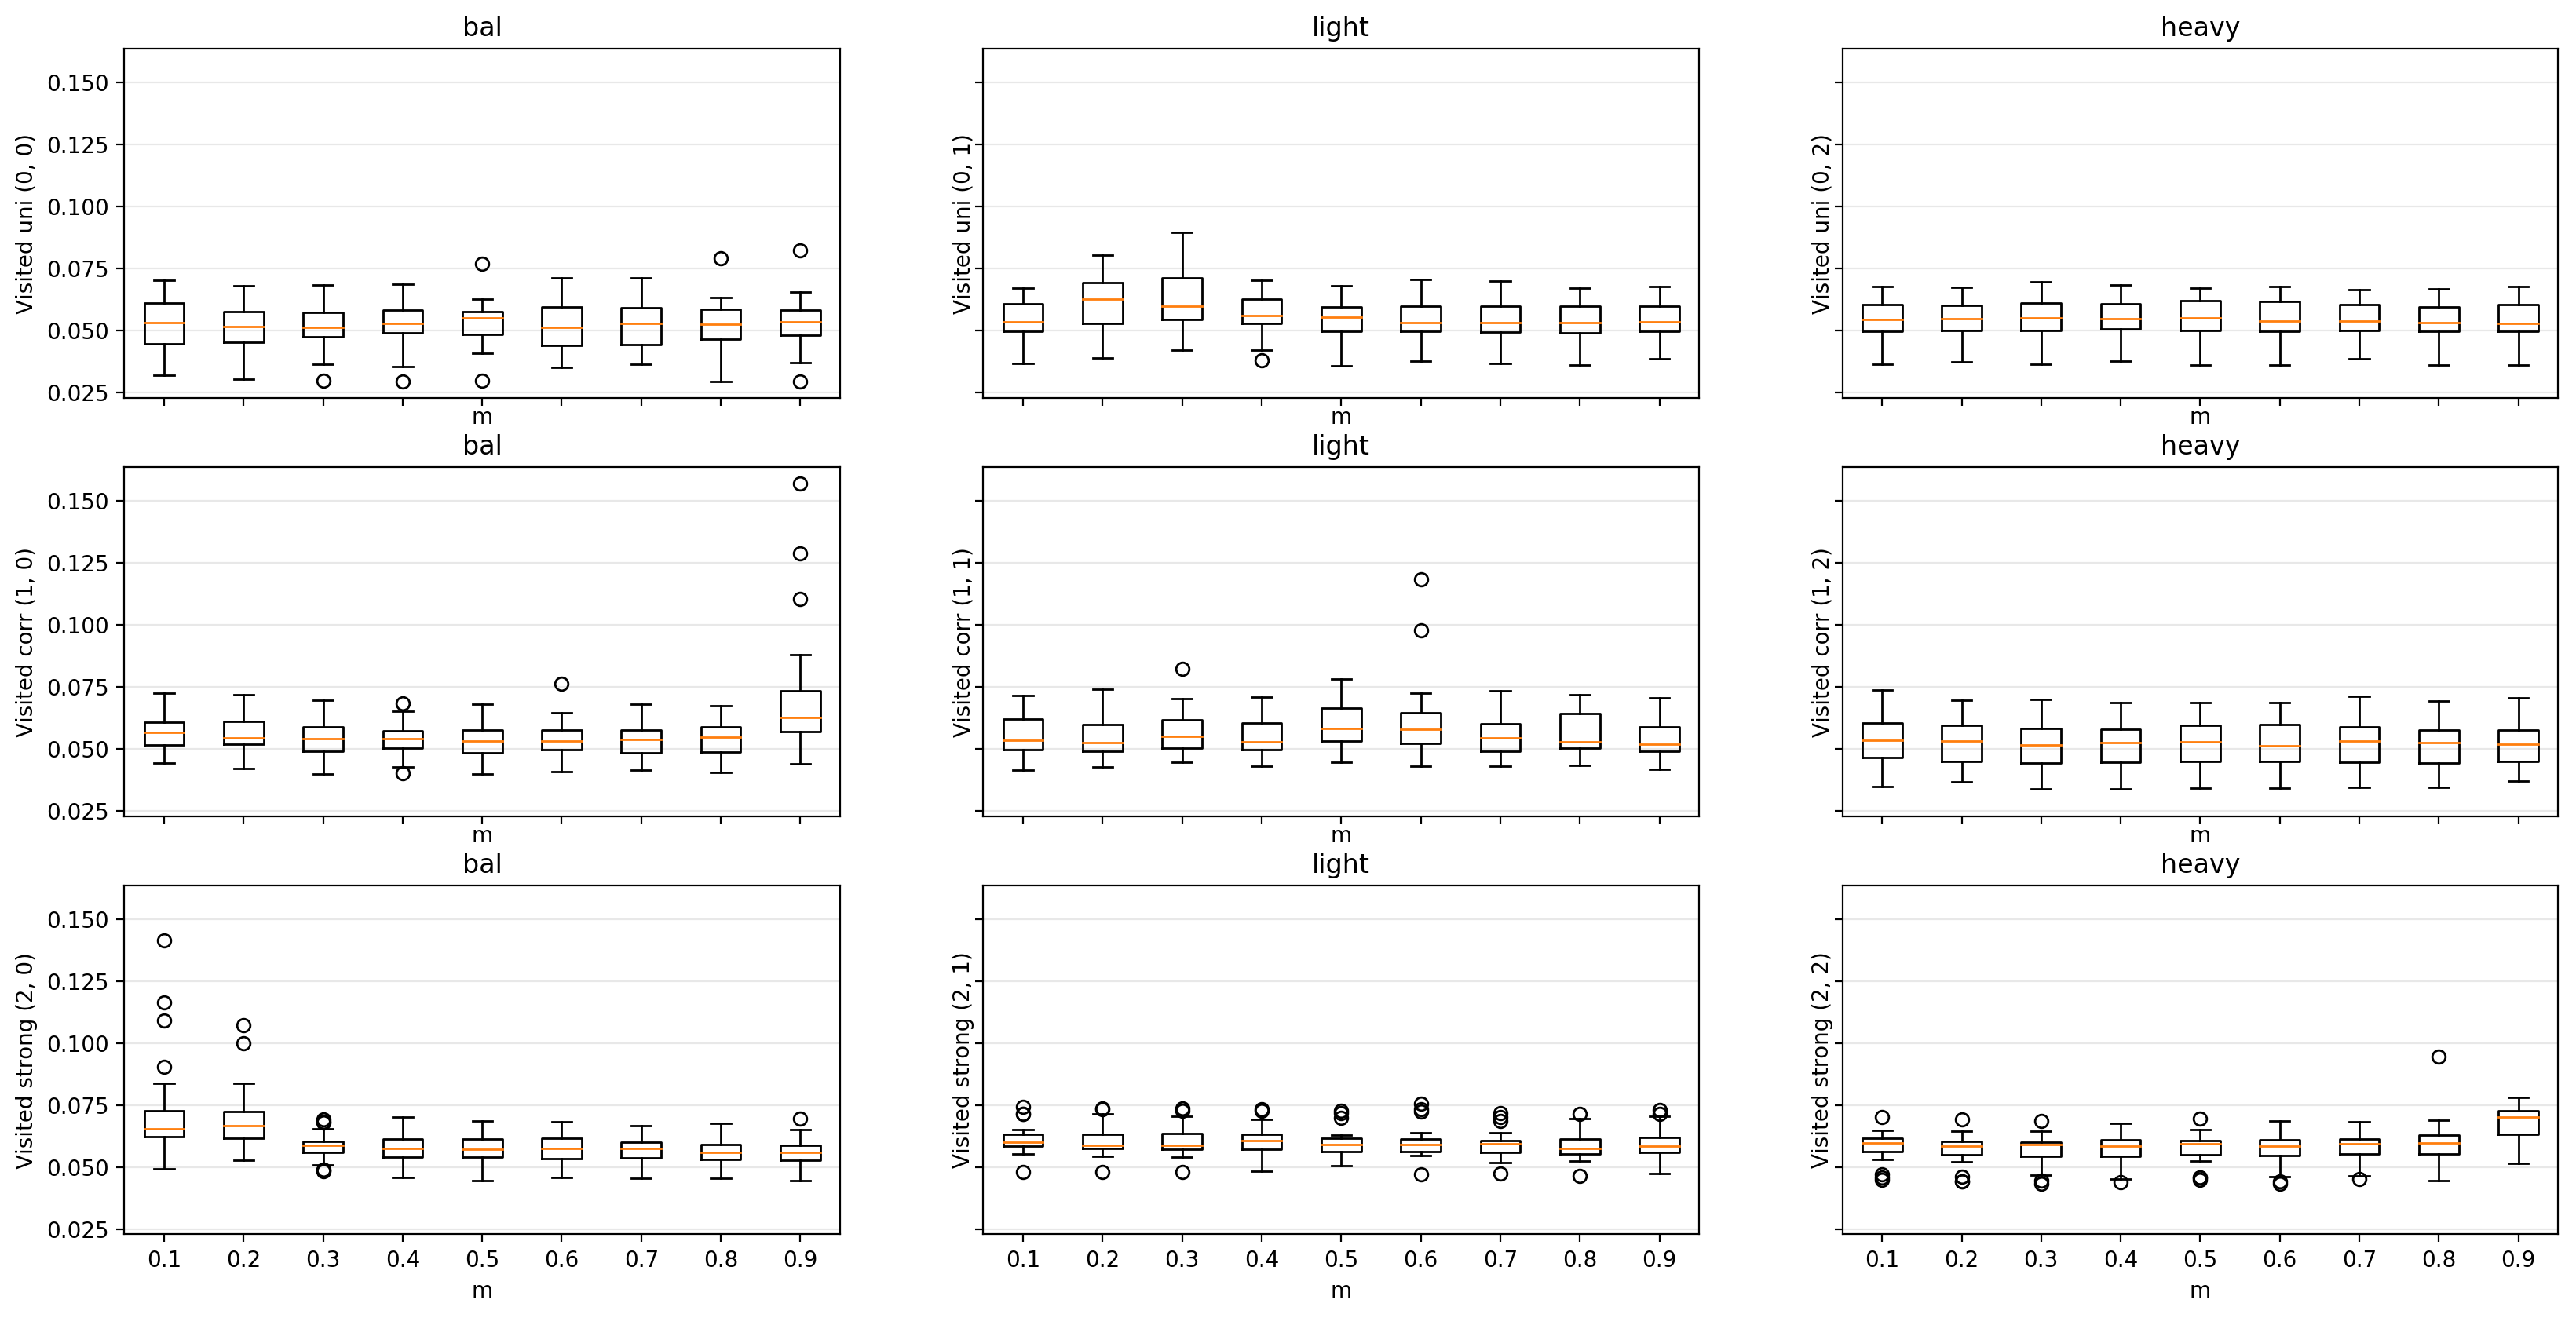

In [518]:
plot_all(n, 25, 100, 100, full_ms, 0, S.DPIterativeByPrice, time=True)

Sorry, there is rendering problem - I am looking at time measurements. Not number of visited states.

When changing the `m` parameter, nothing much happens. Even if weight to price is correlating.

In [523]:
df = pd.DataFrame()
for k in np.linspace(-2, 4, 9):
    df[str(k)] = solve_instances(generate(n, 25, 100, 100, 0.5, 'light', 'corr', k), S.DPIterative, True)

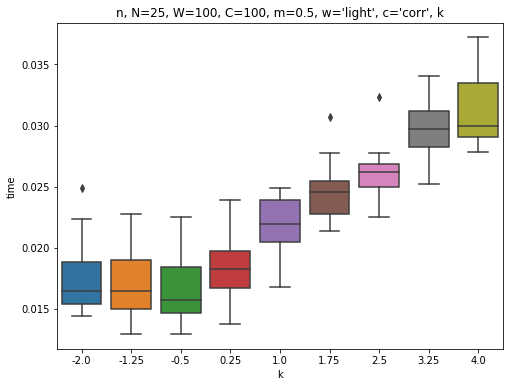

In [525]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df)
plt.title("n, N=25, W=100, C=100, m=0.5, w='light', c='corr', k")
plt.xlabel("k")
plt.ylabel("time")
plt.show()

When rising the boosting `k` parameter, also the complexity is rising. 

## Robustness

In [533]:
stdin = generate(7, 1, 200, 200, 0.5, 'bal', 'uni', 1)
permutations = permute(1, math.factorial(7), '\n'.join(stdin))
print(permutations[:10], end="\n")

result = pd.DataFrame(solve_instances(permutations, S.DPIterativeByPrice, True))

['2 7 268 144 154 51 150 155 43 50 180 38 48 69 78 29 36', '3 7 268 155 43 50 180 144 154 51 150 29 36 69 78 38 48', '4 7 268 50 180 38 48 155 43 69 78 29 36 144 154 51 150', '5 7 268 50 180 51 150 38 48 144 154 69 78 155 43 29 36', '6 7 268 69 78 155 43 50 180 38 48 29 36 144 154 51 150', '7 7 268 38 48 69 78 155 43 144 154 29 36 50 180 51 150', '8 7 268 51 150 155 43 144 154 29 36 69 78 38 48 50 180', '9 7 268 38 48 144 154 50 180 29 36 69 78 51 150 155 43', '10 7 268 50 180 155 43 29 36 38 48 144 154 69 78 51 150', '11 7 268 38 48 144 154 69 78 155 43 51 150 50 180 29 36']


In [534]:
print("mean: ", result.mean())
print("std: ", result.std())

mean:  0    0.021479
dtype: float64
std:  0    0.000714
dtype: float64


This algorithm also looks pretty robust. The variance is definitely caused by the time measuring variance.

# Heuristic - Greedy by price/weight (+ Redux)

bal; uni, corr, strong, light; uni, corr, strong, heavy; uni, corr, strong, 

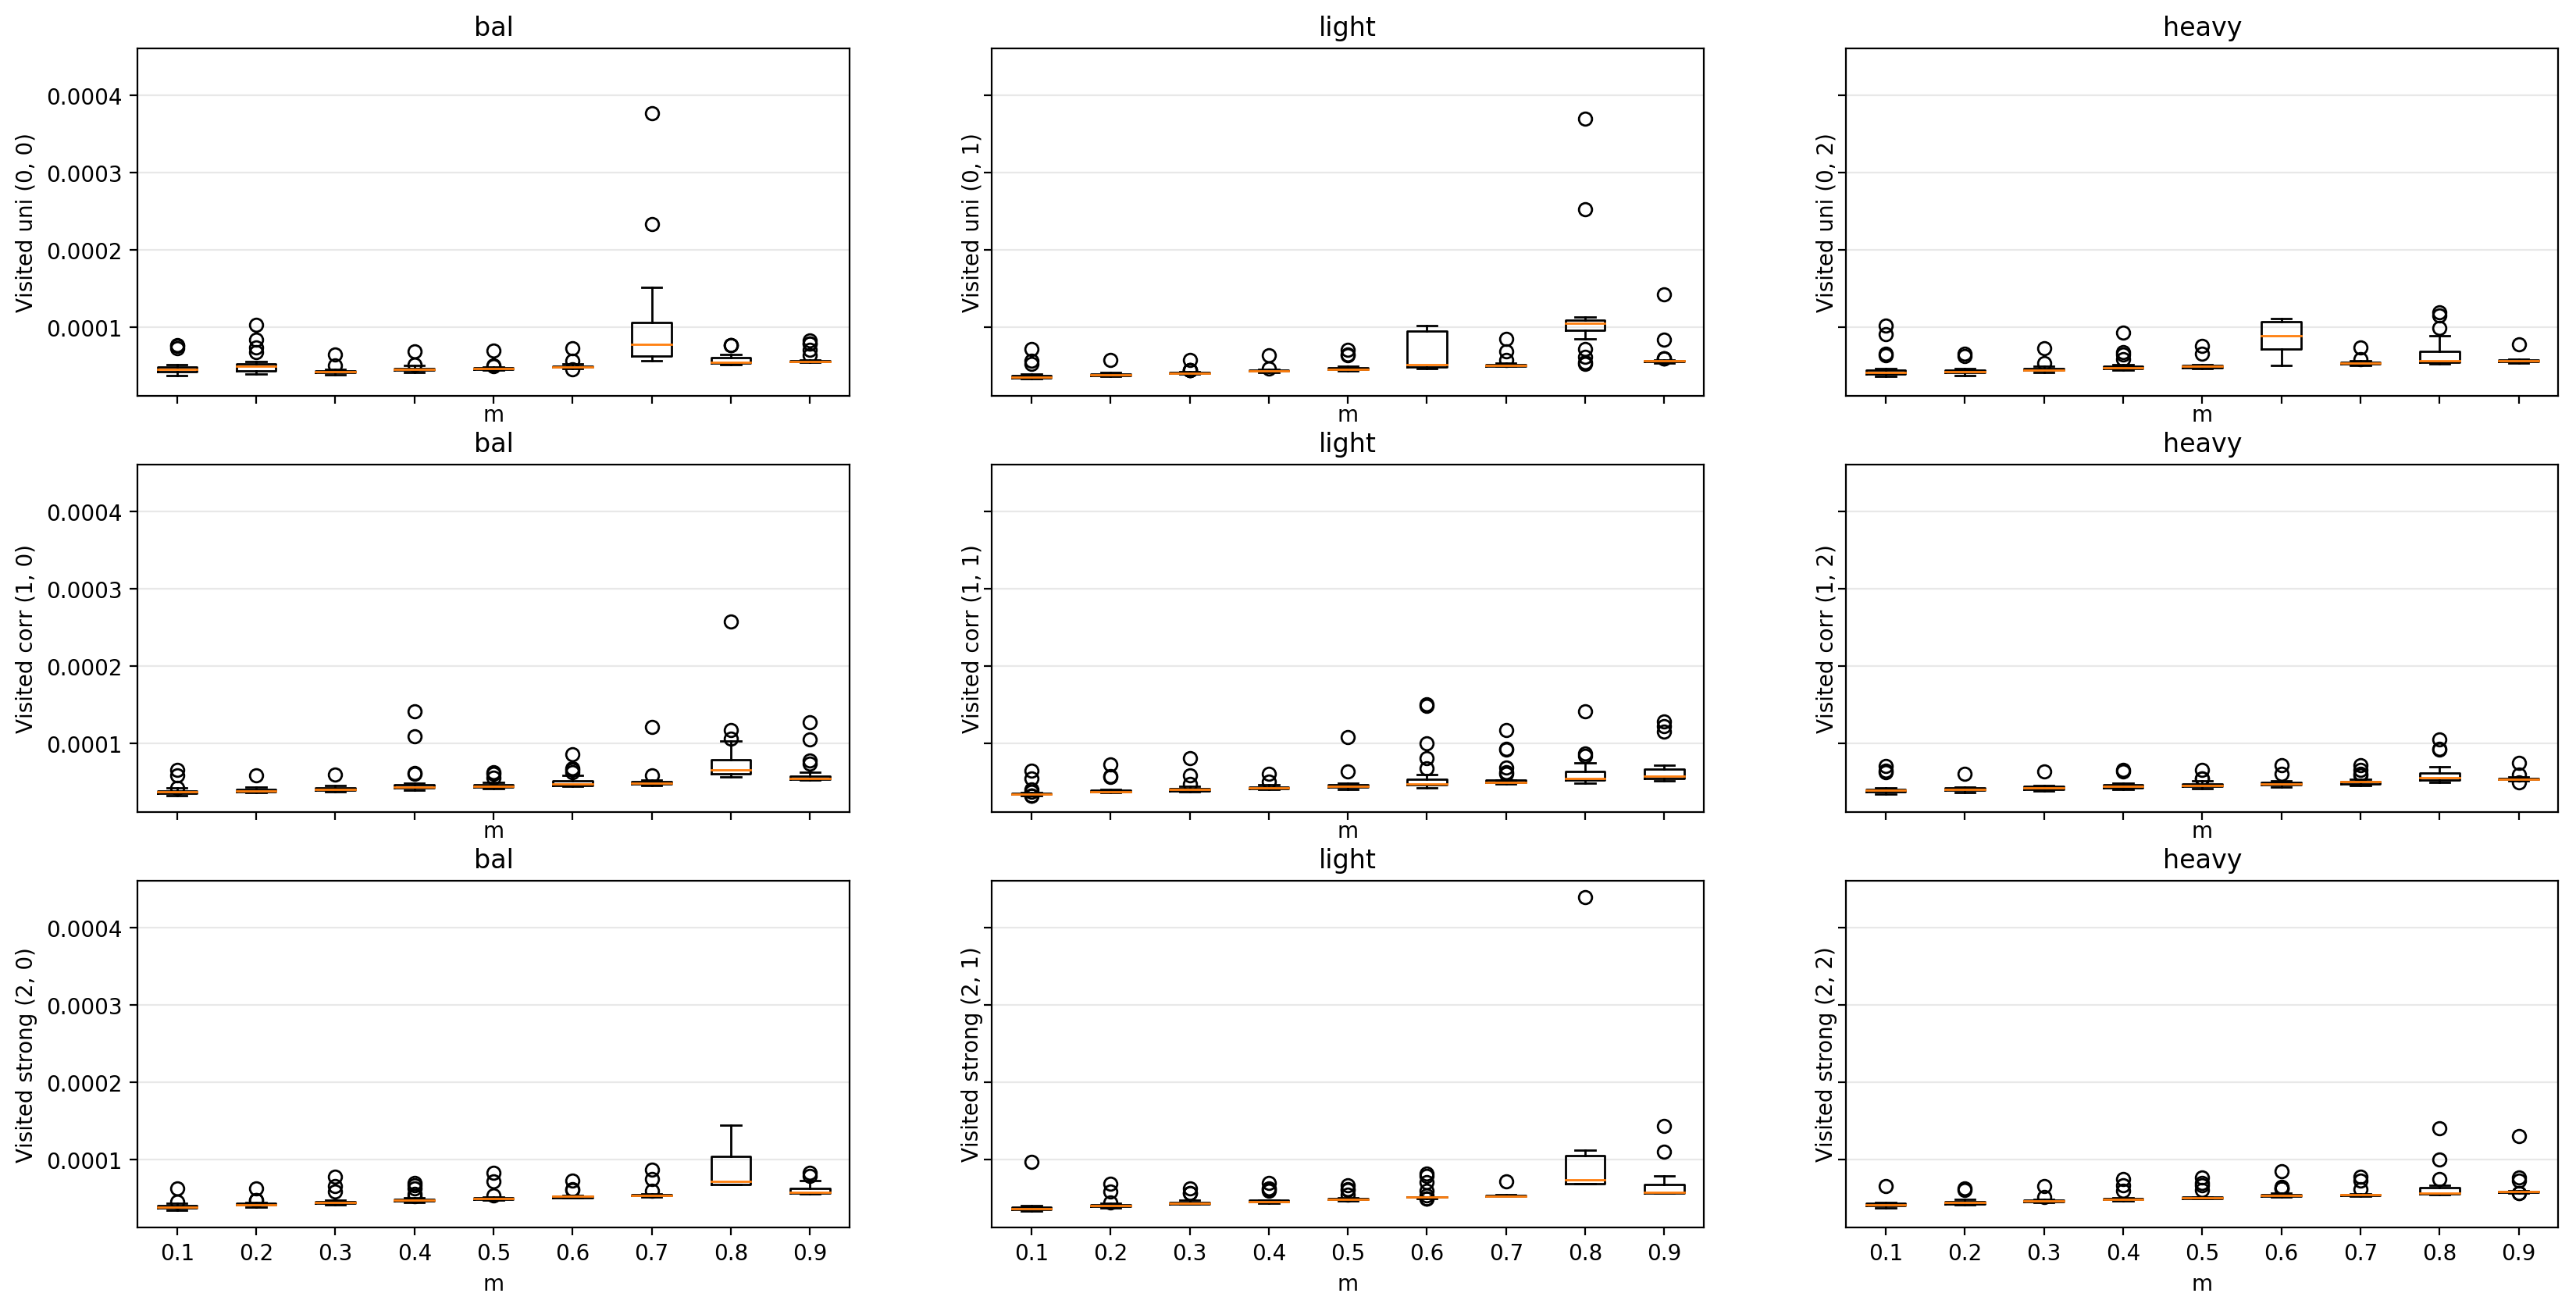

In [537]:
plot_all(20, 25, 1000, 100, full_ms, 1, S.GreedyRedux, time=True)

Again, sorry for the wrong naming on y-axis. It should be Time. Not Visited.

Anyways, the time measured is pretty much the same, even if changing the parameters. 

## Error - accuracy
computing optimal price with BnB and then comparing with Greedy redux heuristic

In [3]:
def get_accuracy(inst_lines, solver_heuristic, solver_exact):
    results = []
    for i in range(0, len(inst_lines)):
        inst = list(map(int, inst_lines[i].split()))
        p = Problem(inst[0], inst[1], inst[2], np.array(inst[3::2]), np.array(inst[4::2]))
        
        solver = solver_heuristic(p)
        solver.solve()
        suboptimal = solver.p.max_price
        
        solver = solver_exact(p)
        solver.solve()
        optimal = solver.p.max_price
        
        results.append(int(optimal == suboptimal))
        
    acc = np.mean(results) * 100
    return acc

In [32]:
def trik_se_spicatym_kloboukem(n, N, Ws, Cs, ms, w, c, k, solver_heuristic, solver_exact):
    fig, axs = plt.subplots(len(Cs), len(Ws), sharey=True, sharex=True, figsize=(20, 20), dpi=200)
    for (x,y), value in np.ndenumerate(axs):
        axs[x,y].yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

    for col in range(len(Ws)):
        print(Ws[col], end='; ')
        for row in range(len(Cs)):
            print(Cs[row], end=', ')
            results = []
            for m in ms:
                inst_lines = generate(n, N, Ws[col], Cs[row], m, w, c, k)
                acc = get_accuracy(inst_lines, solver_heuristic, solver_exact)
#                 print("m: " + str(m) + " acc: " + str(acc))
                results.append(acc)
#                 print(results)
#             print(results)
            ax = axs[row, col]
            ax.bar(ms, results, width=0.05, align='center')
            ax.set_title("Max Weight: " + str(Ws[col]))
            ax.set_ylabel("Accuracy. Price: " + str(Cs[row]))
            ax.set_xlabel("m")
            ax.set_xticklabels(ms)

100; 100, 400, 700, 1000, 400; 100, 400, 700, 1000, 700; 100, 400, 700, 1000, 1000; 100, 400, 700, 1000, 

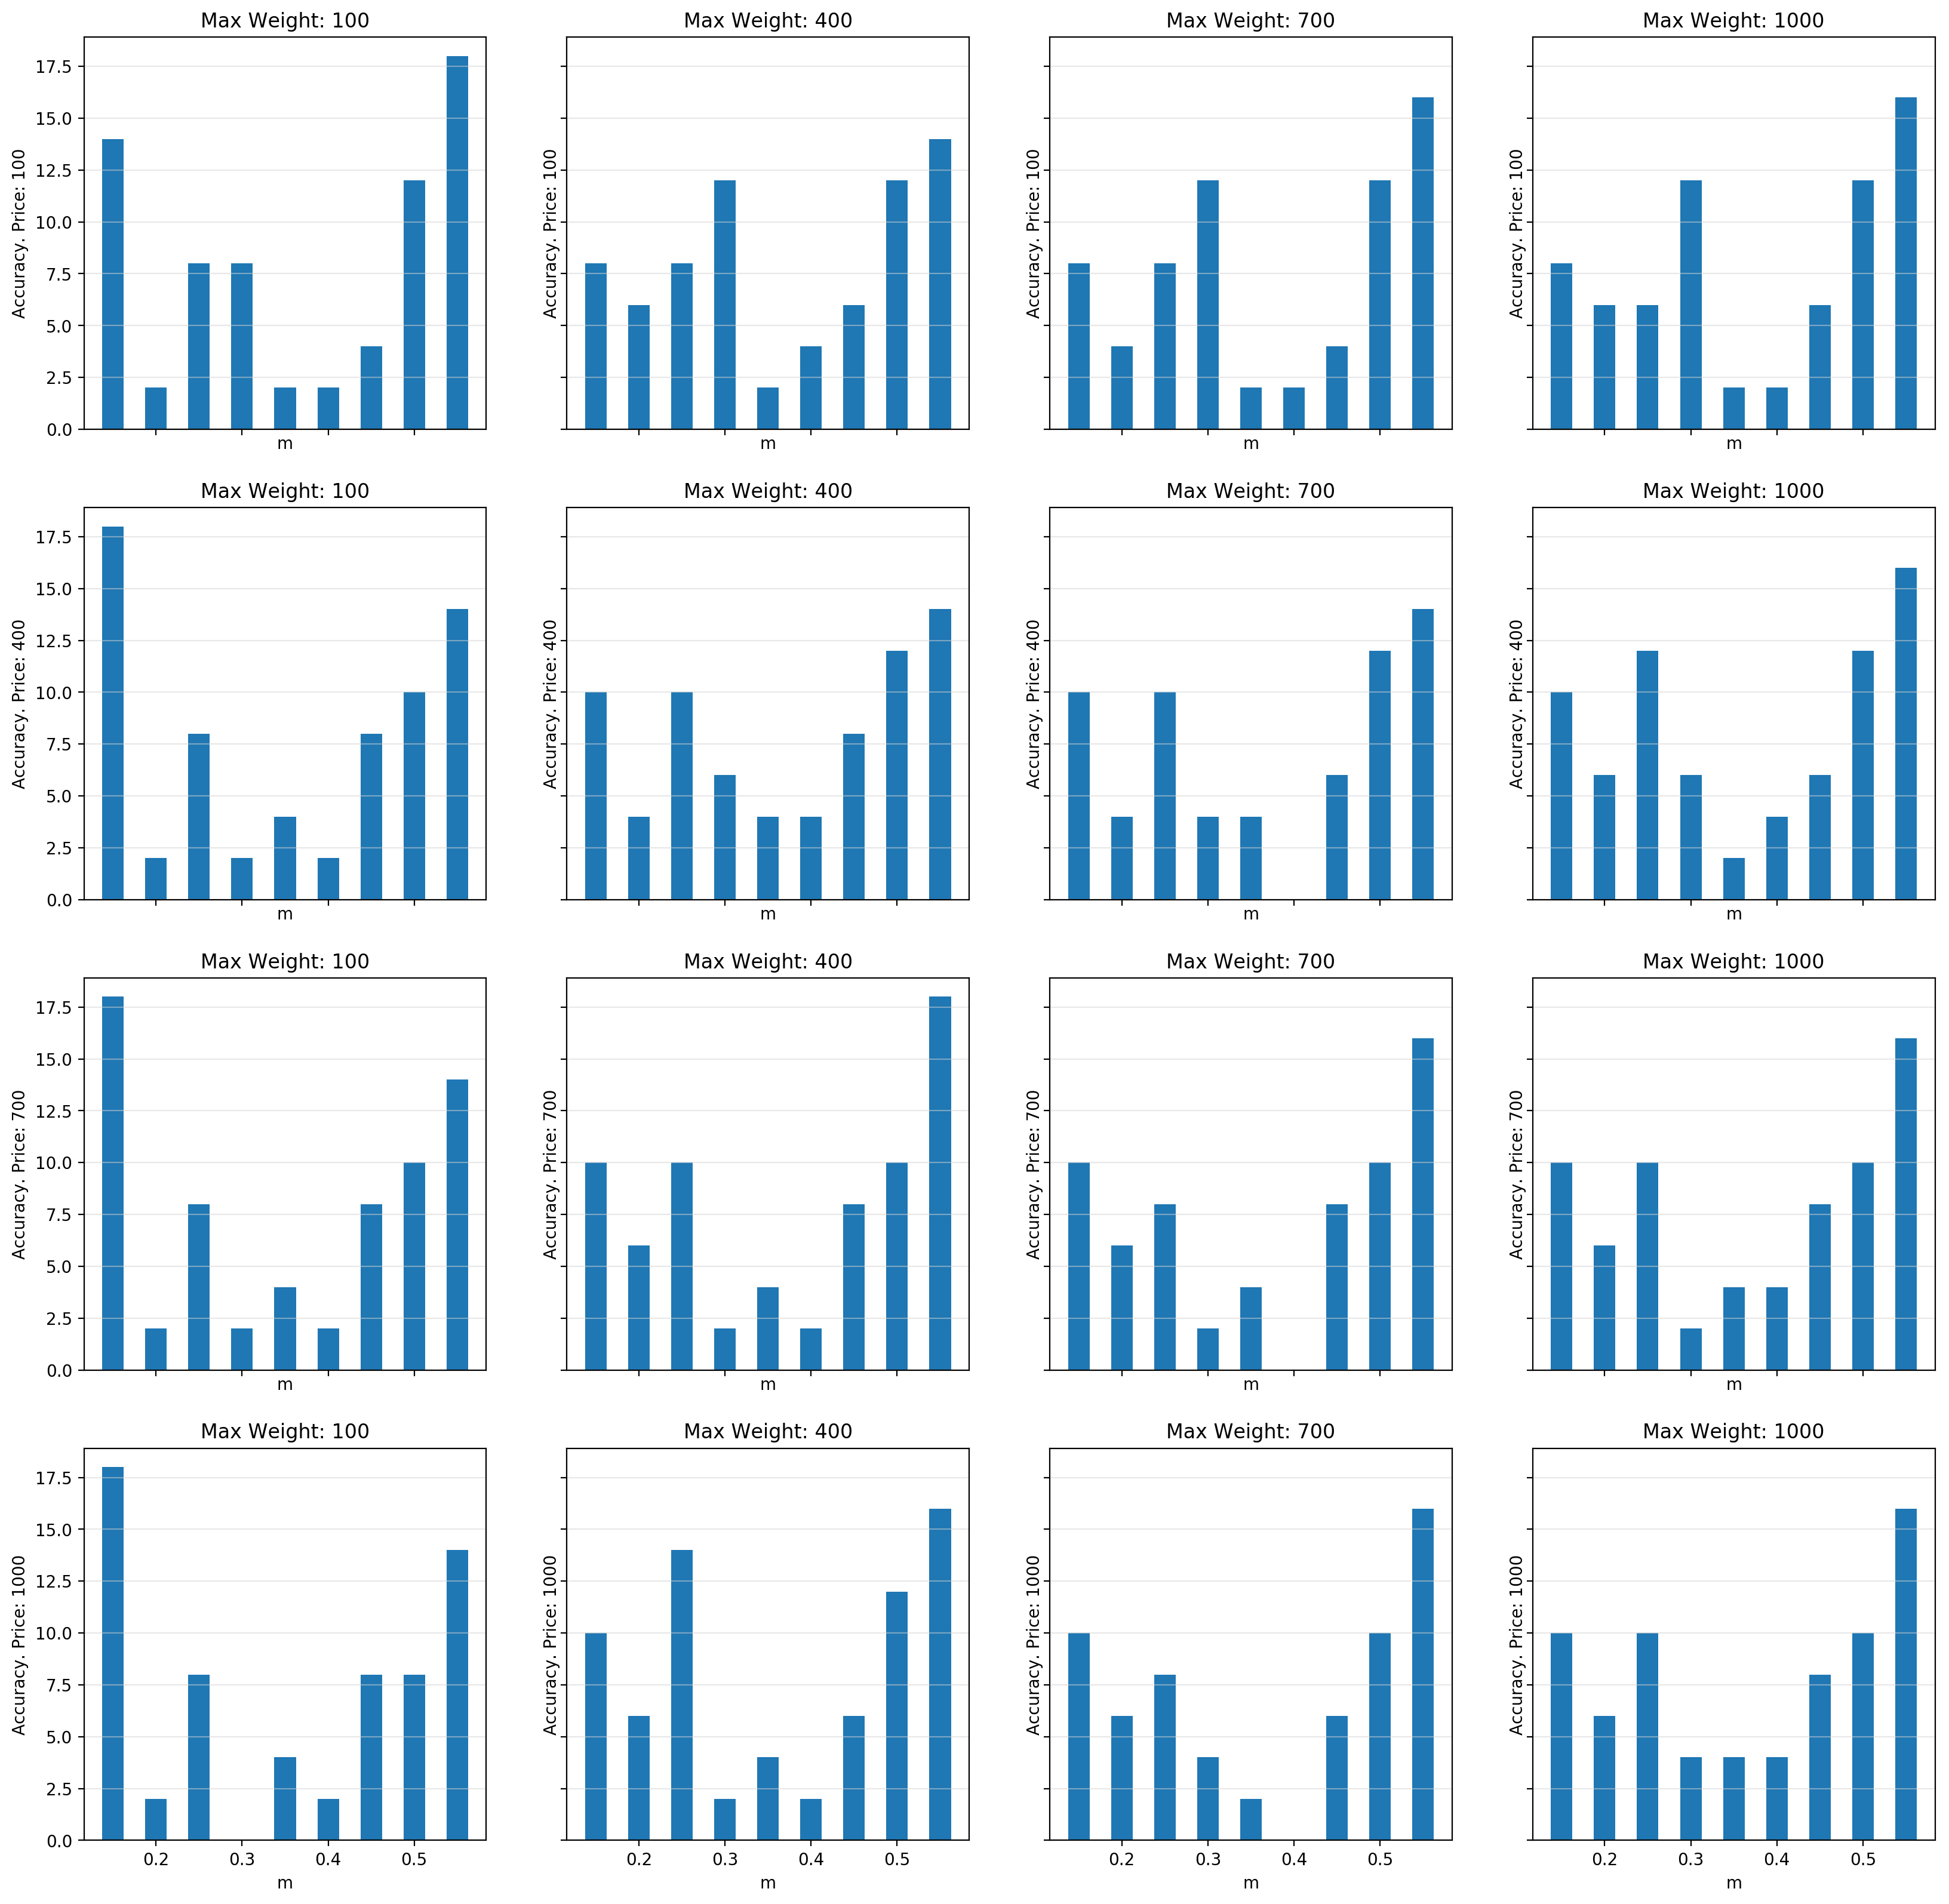

In [36]:
trik_se_spicatym_kloboukem(15, 50, Ws, Cs, ms, 'light', 'corr', 1, S.GreedyRedux, S.BranchBound)

It does not look like the max price/weight has effect on the accuracy.

In [39]:
def plot_accuracy(n, N, W, C, ms, ws, cs, k, solver_heuristic, solver_exact):
    
    fig, axs = plt.subplots(len(ws), len(cs), sharey=True, sharex=True, figsize=(20, 10), dpi=200)
    for (x,y), value in np.ndenumerate(axs):
        axs[x,y].yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

    for col in range(len(ws)):
        print(ws[col], end='; ')
        for row in range(len(cs)):
            print(cs[row], end=', ')
            results = []
            for m in ms:
                inst_lines = generate(n, N, Ws[col], Cs[row], m, ws[col], cs[row], k)
                acc = get_accuracy(inst_lines, solver_heuristic, solver_exact)
                results.append(acc)
            ax = axs[row, col]
            ax.bar(ms, results, width=0.05, align='center')
            ax.set_title(ws[col])
            ax.set_ylabel("Visited " + cs[row] + " " + str((row, col)))
            ax.set_xlabel("m")
            ax.set_xticklabels(ms)

bal; uni, corr, strong, light; uni, corr, strong, heavy; uni, corr, strong, 

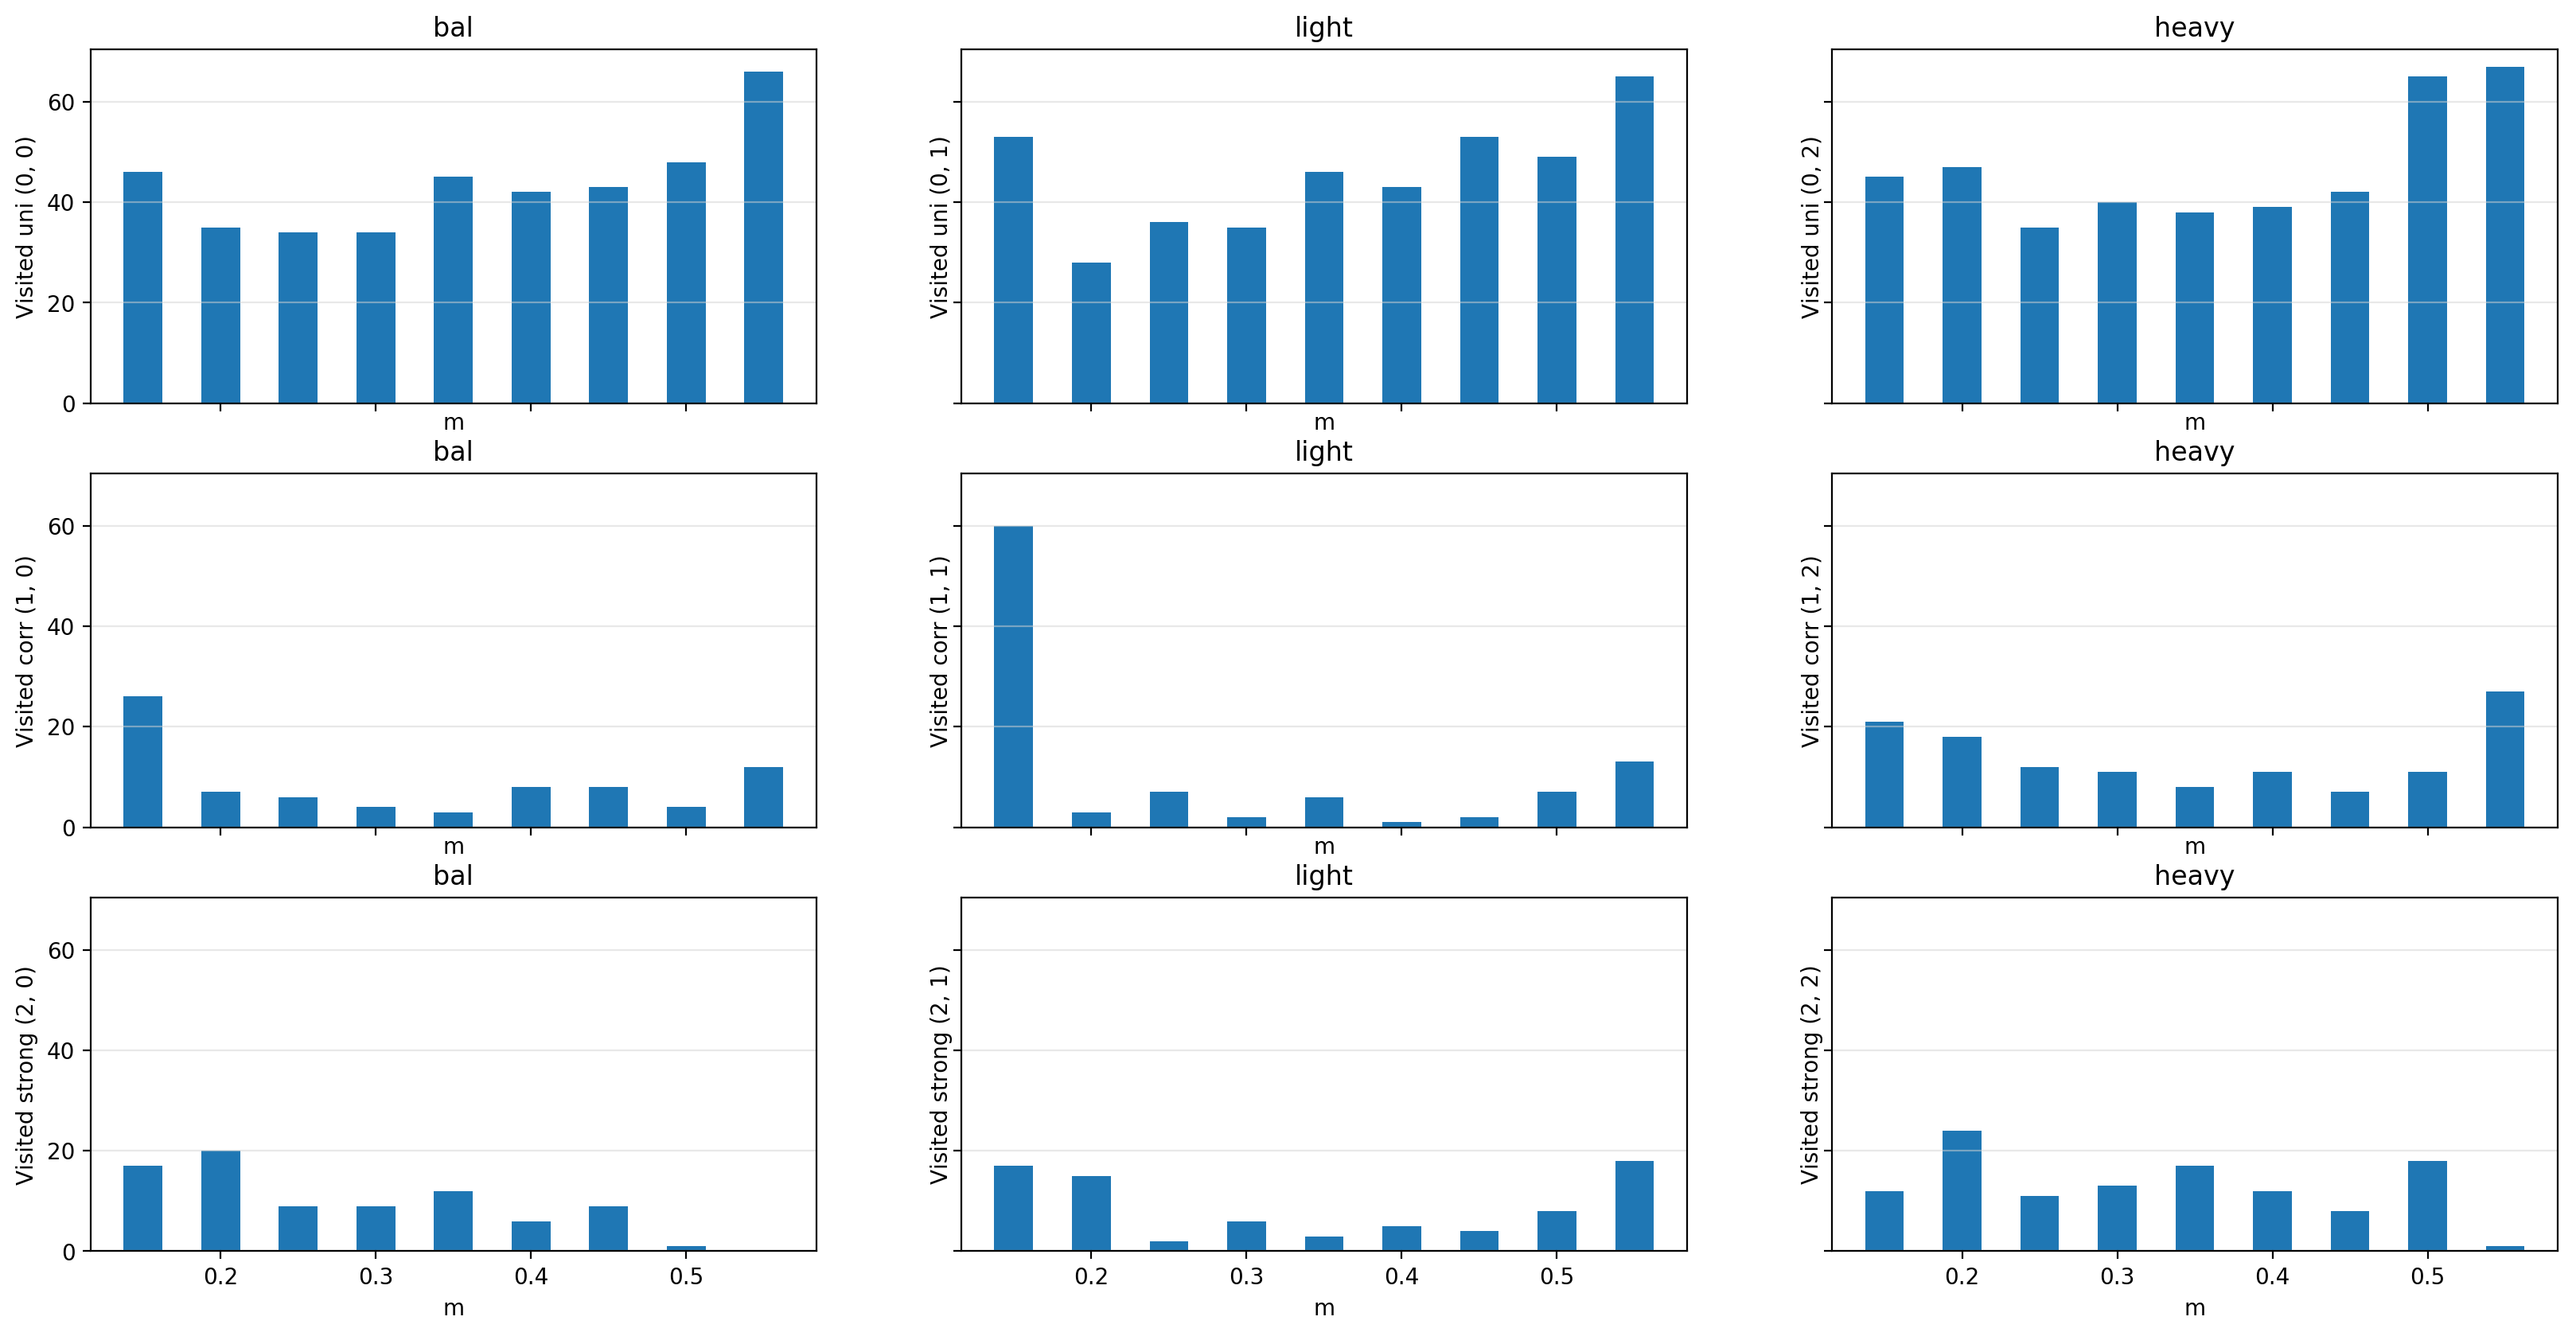

In [43]:
plot_accuracy(13, 100, 100, 100, ms, ws, cs, 1, S.GreedyRedux, S.BranchBound)

Here we can see that the correlation is the key to succes for this heuristic. Strongly correlated weigh/price has bad effect on the accuracy.

In [62]:
result = []
ks = np.linspace(-2, 4, 9)
for k in ks:
    inst_lines = generate(15, 100, 100, 100, 0.2, 'heavy', 'corr', k)
    acc = get_accuracy(inst_lines, S.GreedyRedux, S.BranchBound)
    result.append(acc)

<BarContainer object of 9 artists>

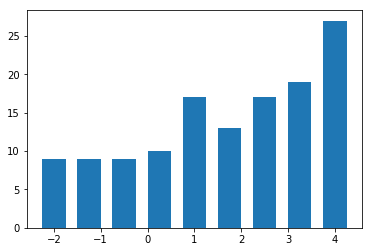

In [63]:
plt.bar(ks, result, width=0.5, align='center')

y-axis is accuracy, x-axis is various `k` parameter. Other parameters are: `n=15, N=100, W=100, C=100, m=0.2, w='heavy', c='corr'`.

The accuracy is getting better, if boosting heavy items. It would be the opposite trend, if having lighter items.


## Robustness
Is no problem here, since I am sorting the input in this greedy method.

# Conclusion

- Prozkoumejte citlivost metod řešení problému batohu na parametry instancí generovaných generátorem náhodných instancí. Máte-li podezření na další závislosti, modifikujte zdrojový tvar generátoru.

*I showed, how changing the parameter of the generator changes or does not change the complexity of given algorithm.*

- Na základě zjištění navrhněte a proveďte experimentální vyhodnocení kvality řešení a výpočetní náročnosti.

*The quality is always 100%, instead of Heuristic algorithm, where I show the accuracy.*

- Prozkoumejte robustnost použitých metod.

*(Un)Fortunately many of my approaches are implemented so that I first sort the given input and then compute the optimal price. So these subtasks were not needed so much.*

- Zkoumejte zejména následující metody
    - hrubá síla (pokud z implementace není evidentní úplná necitlivost na vlastnosti instancí)
    - metoda větví a hranic, případně ve více variantách
    - dynamické programování (dekompozice podle ceny a/nebo hmotnosti). FPTAS algoritmus není nutné testovat, pouze pokud by bylo podezření na jiné chování, než DP
    - heuristika - poměr cena/váha
    
*I showed the complexity and/or accuracy for each of the approach mentioned above.*
    
- Pozorujte zejména závislosti výpočetního času (případně počtu testovaných stavů) a rel. chyby (v případě heuristiky) na:
    - poměru kapacity batohu k sumární váze
    - korelaci cena/váha
    - rozložení vah a granularitě (pozor - zde si uvědomte smysl exponentu granularity)

*I checked all parameters of the generator.*

- Pro toto (citlivostní) vyhodnocení (pro jiné obecně nikoliv) pravděpodobně stačí zafixovat všechny parametry na konstantní hodnotu a vždy plynule měnit jeden parametr. Neumíme vyloučit, že parametry spolu interagují, ale myslíme si, že ne (viz pořekadlo výše).

*With given graph plotting approach it was easy to not have that much pilot experiments, since I was showing many information at once.*

- Je nutné naměřit výsledky pro aspoň čtyři (opravdu minimálně) vhodně zvolené hodnoty parametru, jinak některé závislosti nebude možné vypozorovat.

*I checked all the parameters and the correlation to the complexity of the algorithms.*

- Zpráva by měla obsahovat aspoň stručný popis jednotlivých algoritmů. Jinak nemusí být jasné, jaký typ B&B, DP, ... byl použit.

*I did not changed any of the implementation of the algorithm since the last tasks. Anyways it is showed in the beginning.*